In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d

In [2]:
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude,  PVAangleToRoi, PVA_radian_to_angle,calculateBumpWidth_v1
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation, moving_wrapped_plot_by_offset

In [3]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/PEG_EB(syt)/TQfly091-007-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

Time_Stamp    F_Roi_1   F_Roi_2   F_Roi_3   F_Roi_4    F_Roi_5   
0        0.00000   8.631425  5.317413  5.789597  5.528564   4.489524  \
1        0.10157   9.747514  6.087641  6.872163  6.050715   4.500290   
2        0.20314   8.426873  5.539991  7.693761  5.419640   4.264192   
3        0.30471   6.413872  5.869654  5.917426  6.109918   4.003121   
4        0.40628   5.976976  2.816928  4.325492  5.819246   5.677388   
...          ...        ...       ...       ...       ...        ...   
2949   299.52993   8.465028  5.933520  6.978496  8.866180  15.326129   
2950   299.63150   8.681935  2.480656  5.967175  9.374931  15.829392   
2951   299.73307   5.701256  4.886139  5.897875  8.207876  14.416730   
2952   299.83464   5.432912  3.674143  5.444719  8.901650  18.053434   
2953   299.93621  11.450715  4.081354  6.286876  7.378921  12.710994   

        F_Roi_6    F_Roi_7    F_Roi_8  dFF_Roi_1  ...  PVA_Radian_offset   
0      6.222054  20.909692   9.663126   0.381430  ...           2.394131  \
1      8.689051  24.508536  10.500715   0.396316  ...           2.514940   
2      8.153482  23.667989  11.266648   0.232062  ...           2.341142   
3      9.325356  24.446397   6.878575   0.212993  ...           1.884135   
4     11.636780  15.904128   5.307126   0.212993  ...           1.949295   
...         ...        ...        ...        ...  ...                ...   
2949   6.674455   5.390489   6.791732   0.270730  ...          -0.184339   
2950   5.547352   6.855858   5.784387   0.263973  ...          -0.031100   
2951   8.987308   8.286667   5.197722   0.175632  ...           0.206996   
2952   8.428039   6.212881   6.955757   0.175632  ...           0.268993   
2953   9.391455   6.516517   7.678069   0.150366  ...           0.230686   

       PVA_Angle  Angular_Velocity  Bar_Position/Heading   
0     -34.713736          0.005626             -2.683393  \
1     -27.791913         -0.005381             -2.682821   
2     -37.749770          0.018221             -2.684486   
3     -63.934349         -0.004239             -2.679120   
4     -60.200938         -0.076350             -2.685347   
...          ...               ...                   ...   
2949  177.550835         -1.383132              2.769168   
2950 -173.669238         -2.650334              2.559001   
2951 -160.027325         -1.443471              2.230779   
2952 -156.475194          1.669852              2.265775   
2953 -158.670000          2.995160              2.569993   

      Unwrapped_Bar_Position/Heading  Unwrapped_Radian  Integrated_x   
0                          -2.683393          2.394131      4.356410  \
1                          -2.682821          2.514940      4.353784   
2                          -2.684486          2.341142      4.355373   
3                          -2.679120          1.884135      4.353101   
4                          -2.685347          1.949295      4.357277   
...                              ...               ...           ...   
2949                       -9.797202        -44.166636      4.034957   
2950                      -10.007369        -44.013397      4.032398   
2951                      -10.335591        -43.775301      3.984505   
2952                      -10.300596        -43.713304      4.001070   
2953                       -9.996378        -43.751611      4.055304   

      Integrated_y  PVA_strength  Bump_amplitude  
0        -6.068652      0.977466        0.692899  
1        -6.056768      1.085221        0.806060  
2        -6.049823      0.978164        0.834945  
3        -6.064064      0.964961        0.766286  
4        -6.048122      0.920242        0.752411  
...            ...           ...             ...  
2949     -5.372576      0.641052        0.711992  
2950     -5.333571      0.591147        0.659132  
2951     -5.312284      0.772776        0.697200  
2952     -5.290423      0.532533        0.563991  
2953     -5.310118      0.438412        0.524122  

[2954 rows x 28 columns]

In [4]:
trial_type = 0

In [5]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1]
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [6]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
PVA_Radian = pd_imaging_behavior_preprocessed['PVA_Radian']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']
Wrapped_heading =pd_imaging_behavior_preprocessed['Bar_Position/Heading']

In [7]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


In [8]:
F_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['F_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    F_8_roi[i,0]= pd_imaging_behavior_preprocessed['F_Roi_1'][i]
    F_8_roi[i,1]= pd_imaging_behavior_preprocessed['F_Roi_2'][i]
    F_8_roi[i,2]= pd_imaging_behavior_preprocessed['F_Roi_3'][i]
    F_8_roi[i,3]= pd_imaging_behavior_preprocessed['F_Roi_4'][i]
    F_8_roi[i,4]= pd_imaging_behavior_preprocessed['F_Roi_5'][i]
    F_8_roi[i,5]= pd_imaging_behavior_preprocessed['F_Roi_6'][i]
    F_8_roi[i,6]= pd_imaging_behavior_preprocessed['F_Roi_7'][i]
    F_8_roi[i,7]= pd_imaging_behavior_preprocessed['F_Roi_8'][i]
bump_amplitude_F = calcualteBumpAmplitude(F_8_roi)

In [9]:
dff_normalized_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['dFF_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    dff_normalized_8_roi[i,0]= pd_imaging_behavior_preprocessed['dFF_Roi_1'][i]
    dff_normalized_8_roi[i,1]= pd_imaging_behavior_preprocessed['dFF_Roi_2'][i]
    dff_normalized_8_roi[i,2]= pd_imaging_behavior_preprocessed['dFF_Roi_3'][i]
    dff_normalized_8_roi[i,3]= pd_imaging_behavior_preprocessed['dFF_Roi_4'][i]
    dff_normalized_8_roi[i,4]= pd_imaging_behavior_preprocessed['dFF_Roi_5'][i]
    dff_normalized_8_roi[i,5]= pd_imaging_behavior_preprocessed['dFF_Roi_6'][i]
    dff_normalized_8_roi[i,6]= pd_imaging_behavior_preprocessed['dFF_Roi_7'][i]
    dff_normalized_8_roi[i,7]= pd_imaging_behavior_preprocessed['dFF_Roi_8'][i]

In [10]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

In [11]:
#plt.hist(Angular_velocity_no_series*180/np.pi, bins ='auto')
#plt.title('Angular_velocity distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [12]:
angular_speed_degrees = np.abs(Angular_velocity_no_series*180/np.pi)
#plt.hist(angular_speed_degrees, bins ='auto')
#plt.title('Angular_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [13]:
#plt.hist(Forward_velocity *180/np.pi ,bins='auto')
#plt.title('Forward_velocity distribution', fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [14]:
#plt.hist(Forward_speed_degrees ,bins='auto')
#plt.title('Forward_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

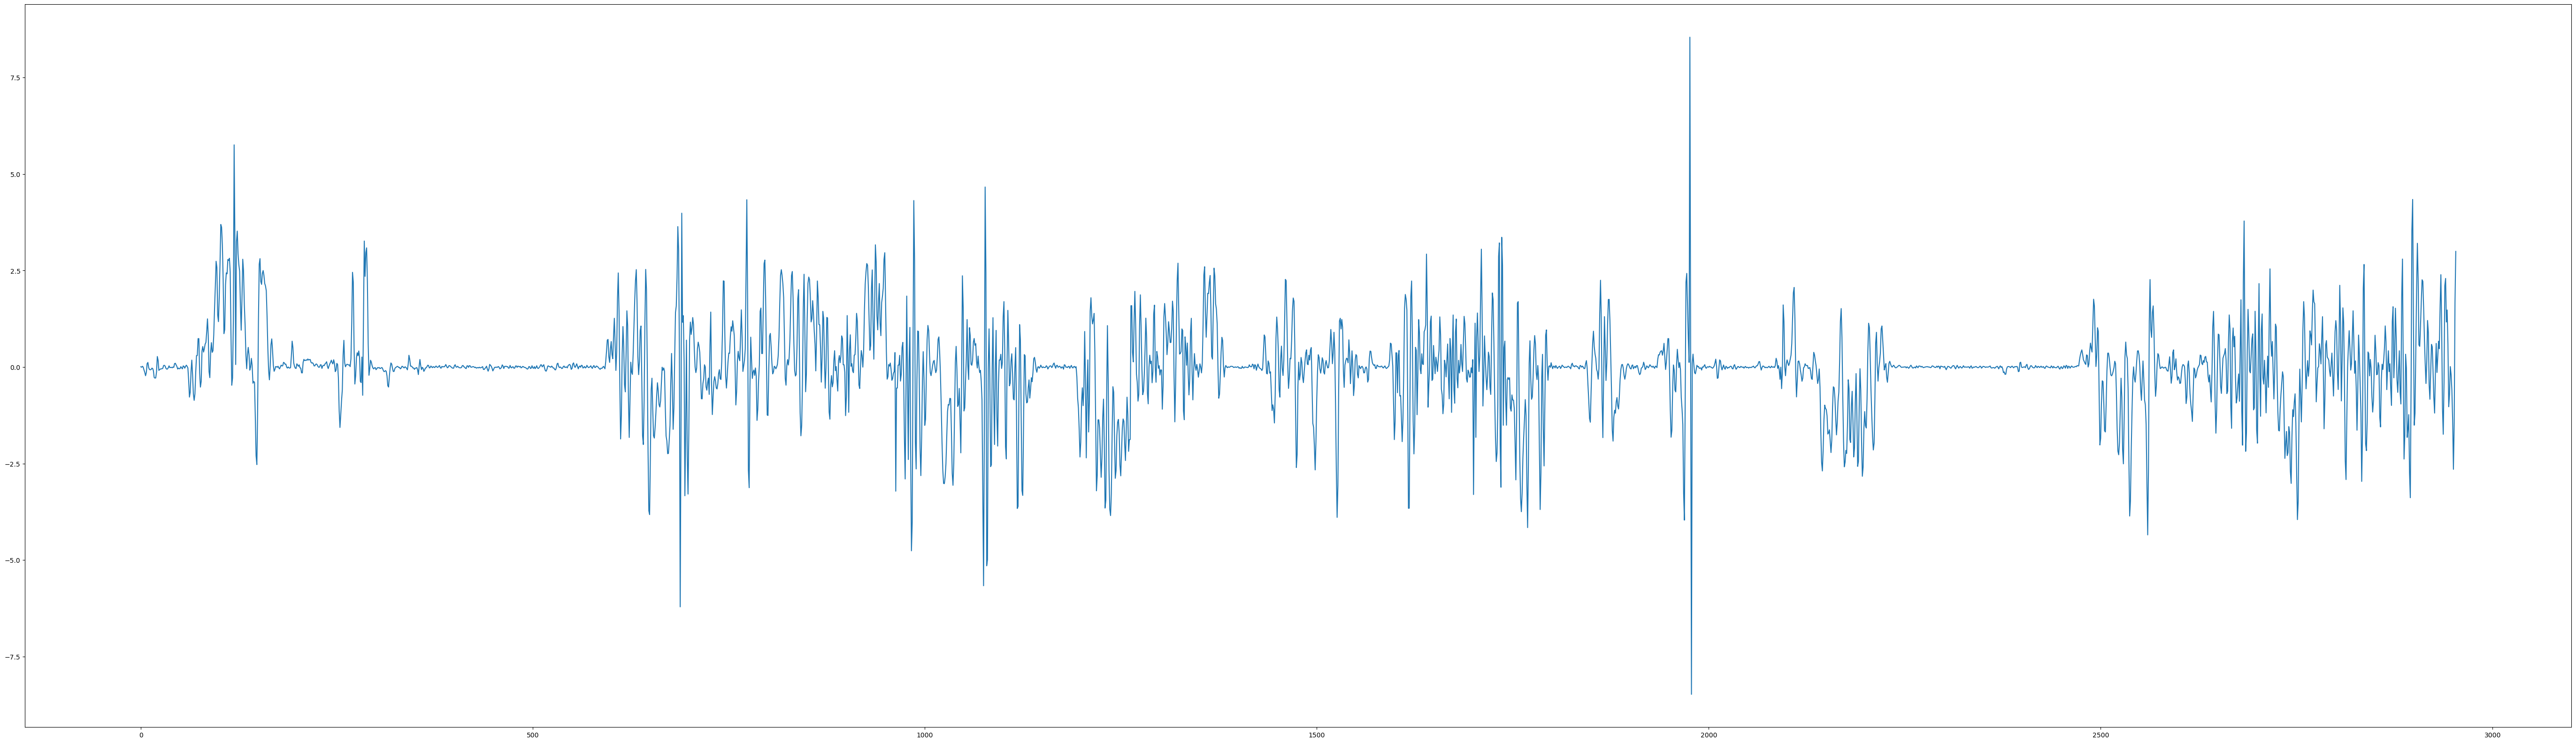

In [15]:
plt.figure(figsize= (70,20))
plt.plot(Angular_velocity)

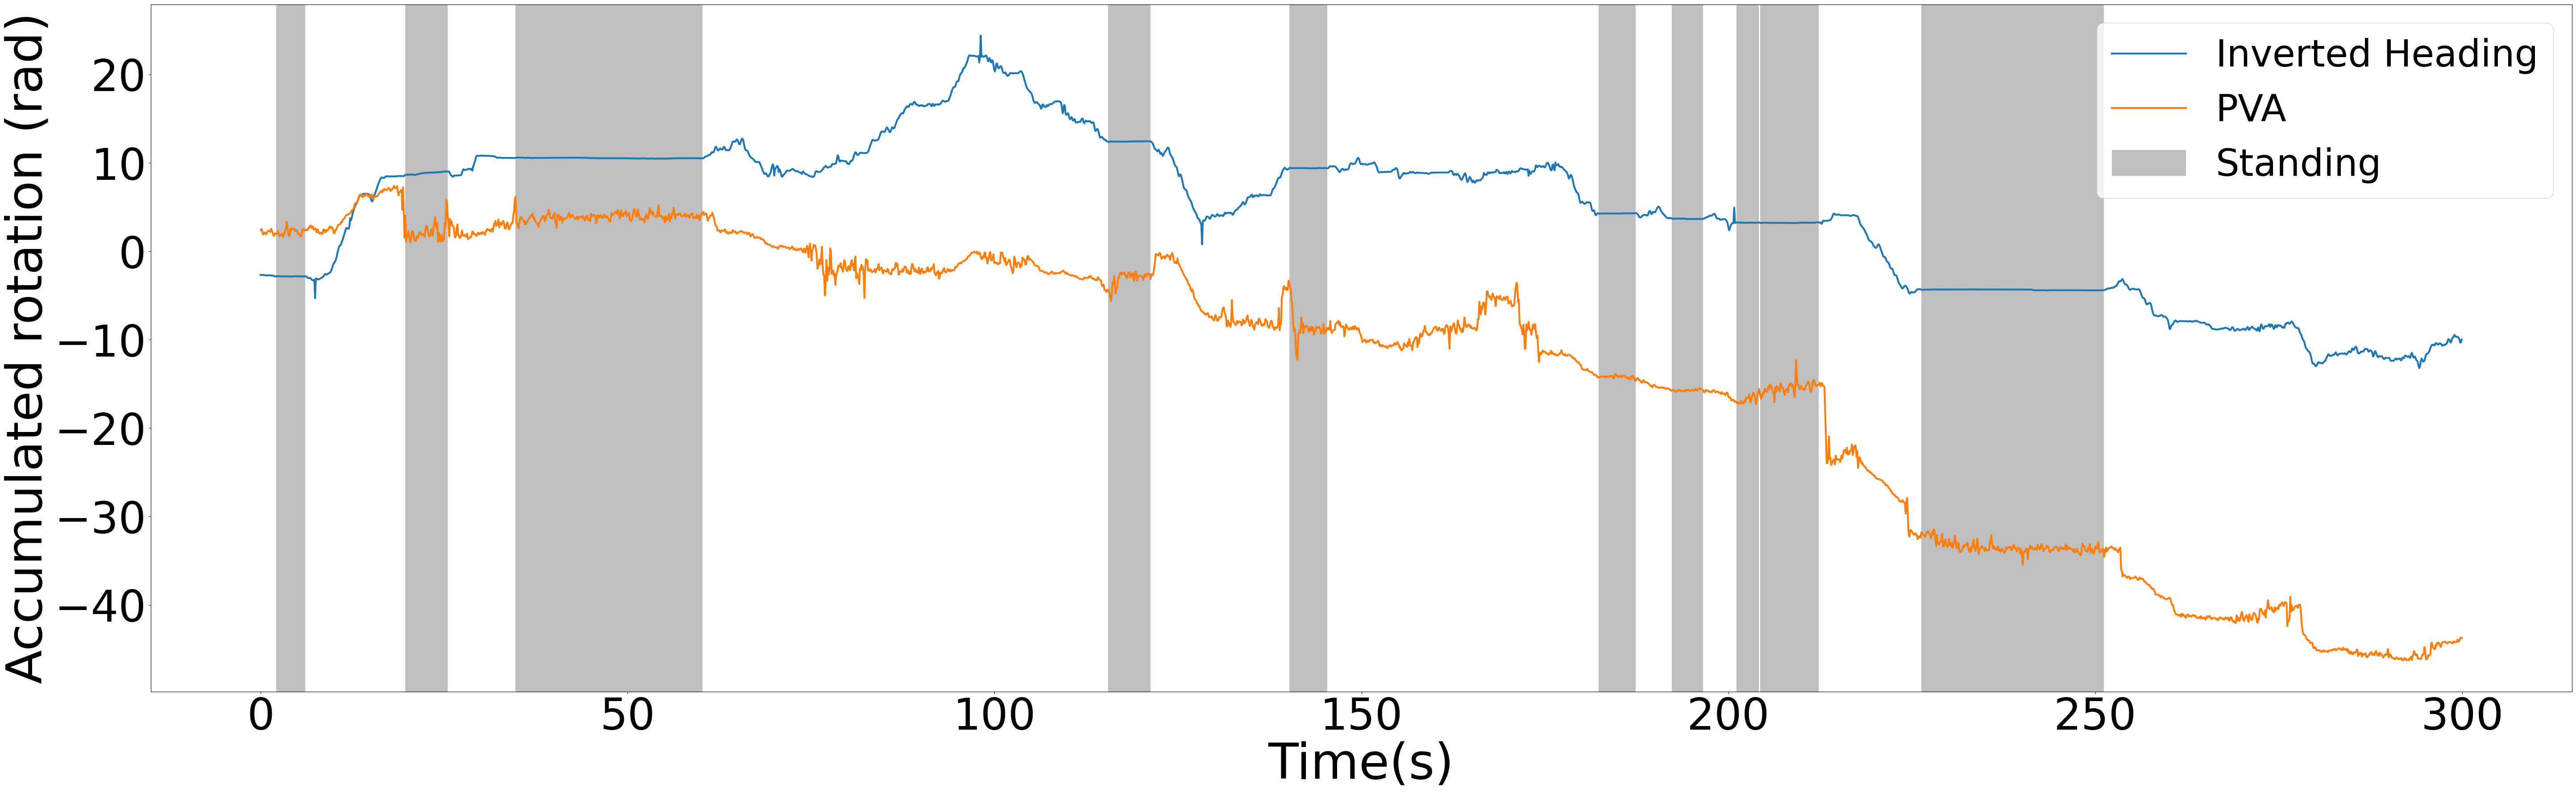

In [16]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.grid()
plt.show()

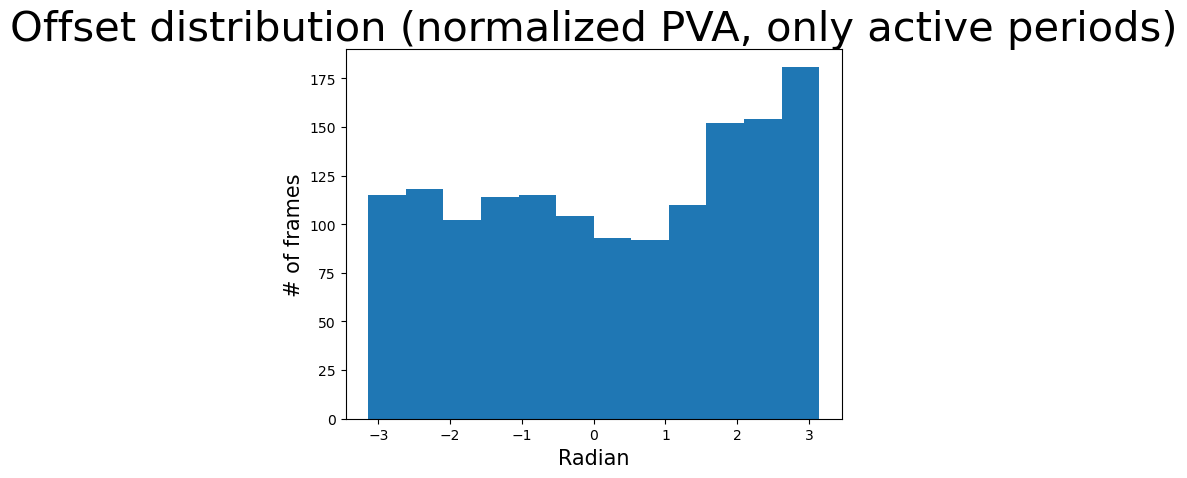

In [17]:
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_Radian, IfRadian = True)
# Bump offset excluding low velocity point
radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity_no_series)):
    if np.abs(Angular_velocity_no_series[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])
plt.hist(radian_offset_no_stopping_period_normalized,bins='auto')
plt.title('Offset distribution (normalized PVA, only active periods)',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

In [18]:
PVA_radian_array_normalized_offset = moving_wrapped_plot_by_offset(PVA_Radian,math.degrees(3), ifRadian =True)

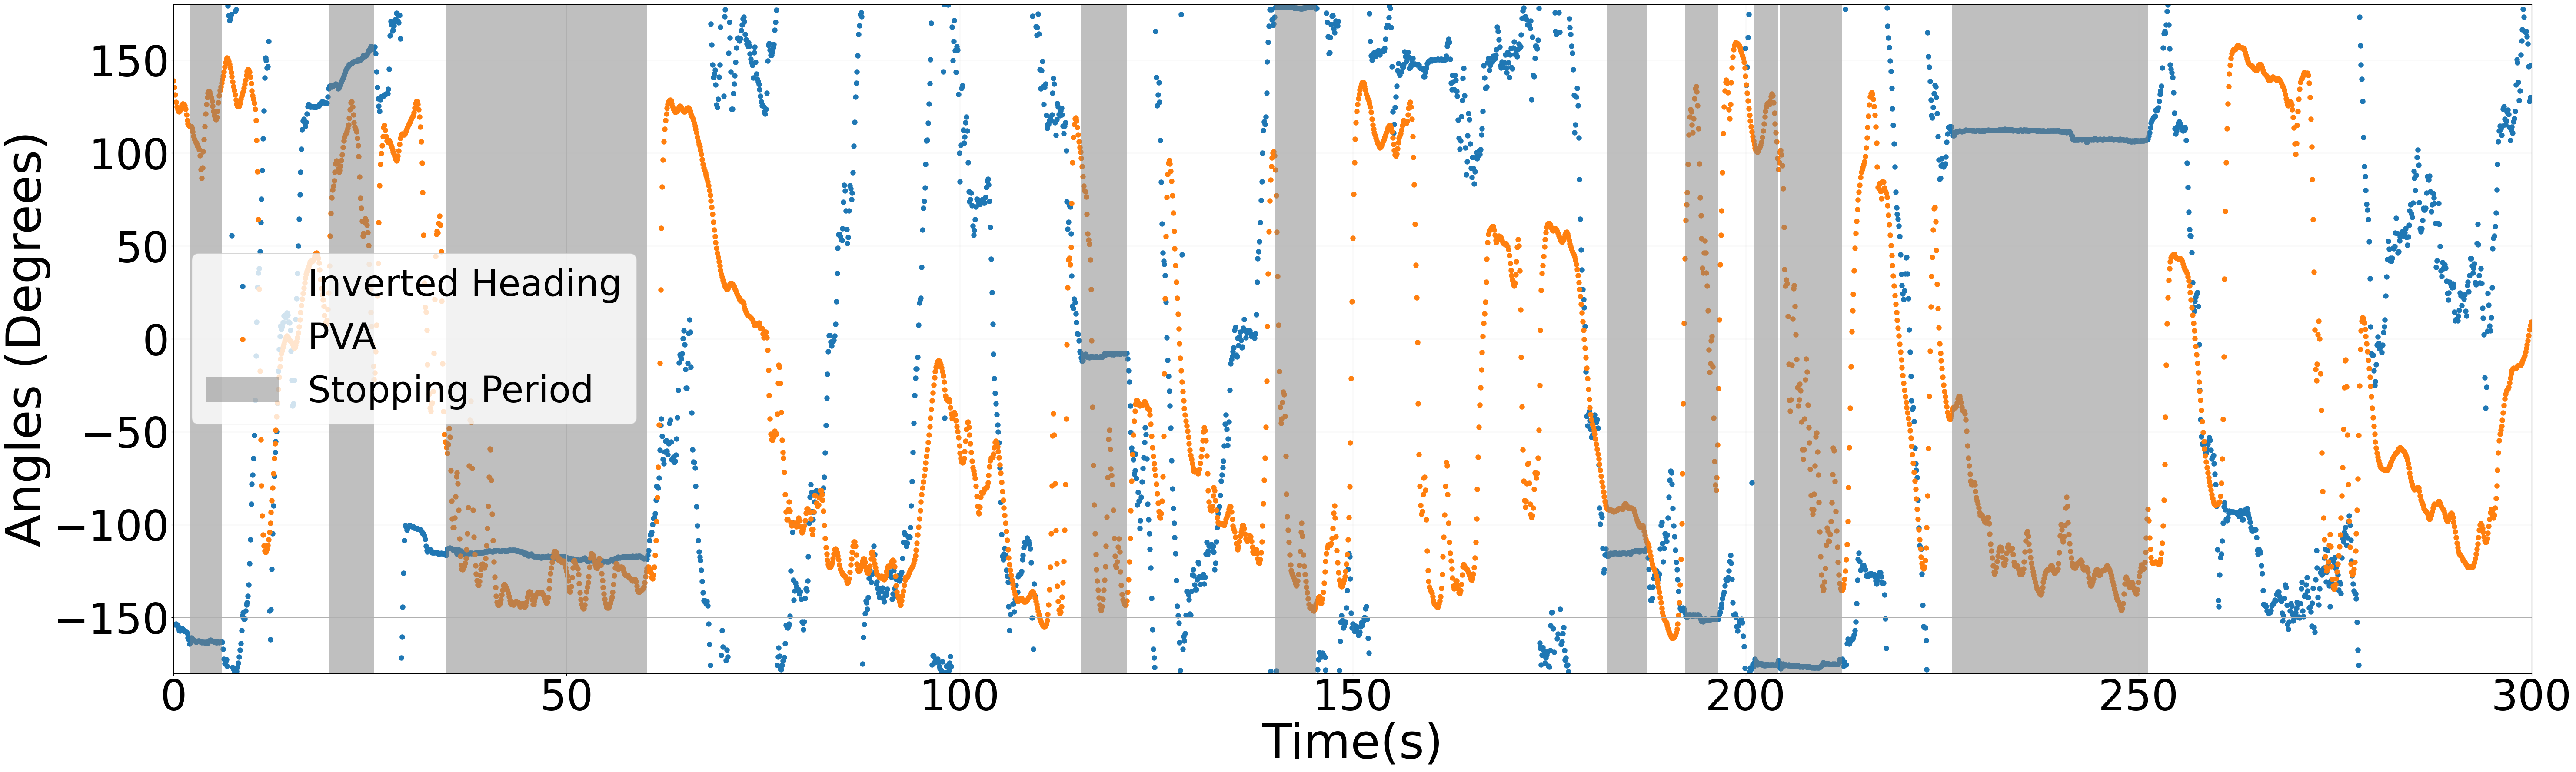

In [19]:
#Plot the stoping period as shaded under wrapped behavior
b = plt.figure(figsize= (70,20))
PVA_radian_array_normalized_offset_filtered = low_pass_filter_TQ(PVA_radian_array_normalized_offset,0.5,volume_rate)
PVA_radian_array_normalized_offset_filtered_angle = PVA_radian_to_angle(PVA_radian_array_normalized_offset_filtered)
Wrapped_heading_angle = PVA_radian_to_angle(Wrapped_heading )

plt.scatter(time_array_imaging,Wrapped_heading_angle ,linewidth =3)
plt.scatter(time_array_imaging,PVA_radian_array_normalized_offset_filtered_angle, linewidth = 3)
plt.xlabel('Time(s)', fontsize=80)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Angles (Degrees)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Stopping Period'],fontsize=60, loc = 4)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylim(-180, 180)
plt.grid()
plt.show()
#b.savefig('Behavior_trace_with_PVA', format ='svg')

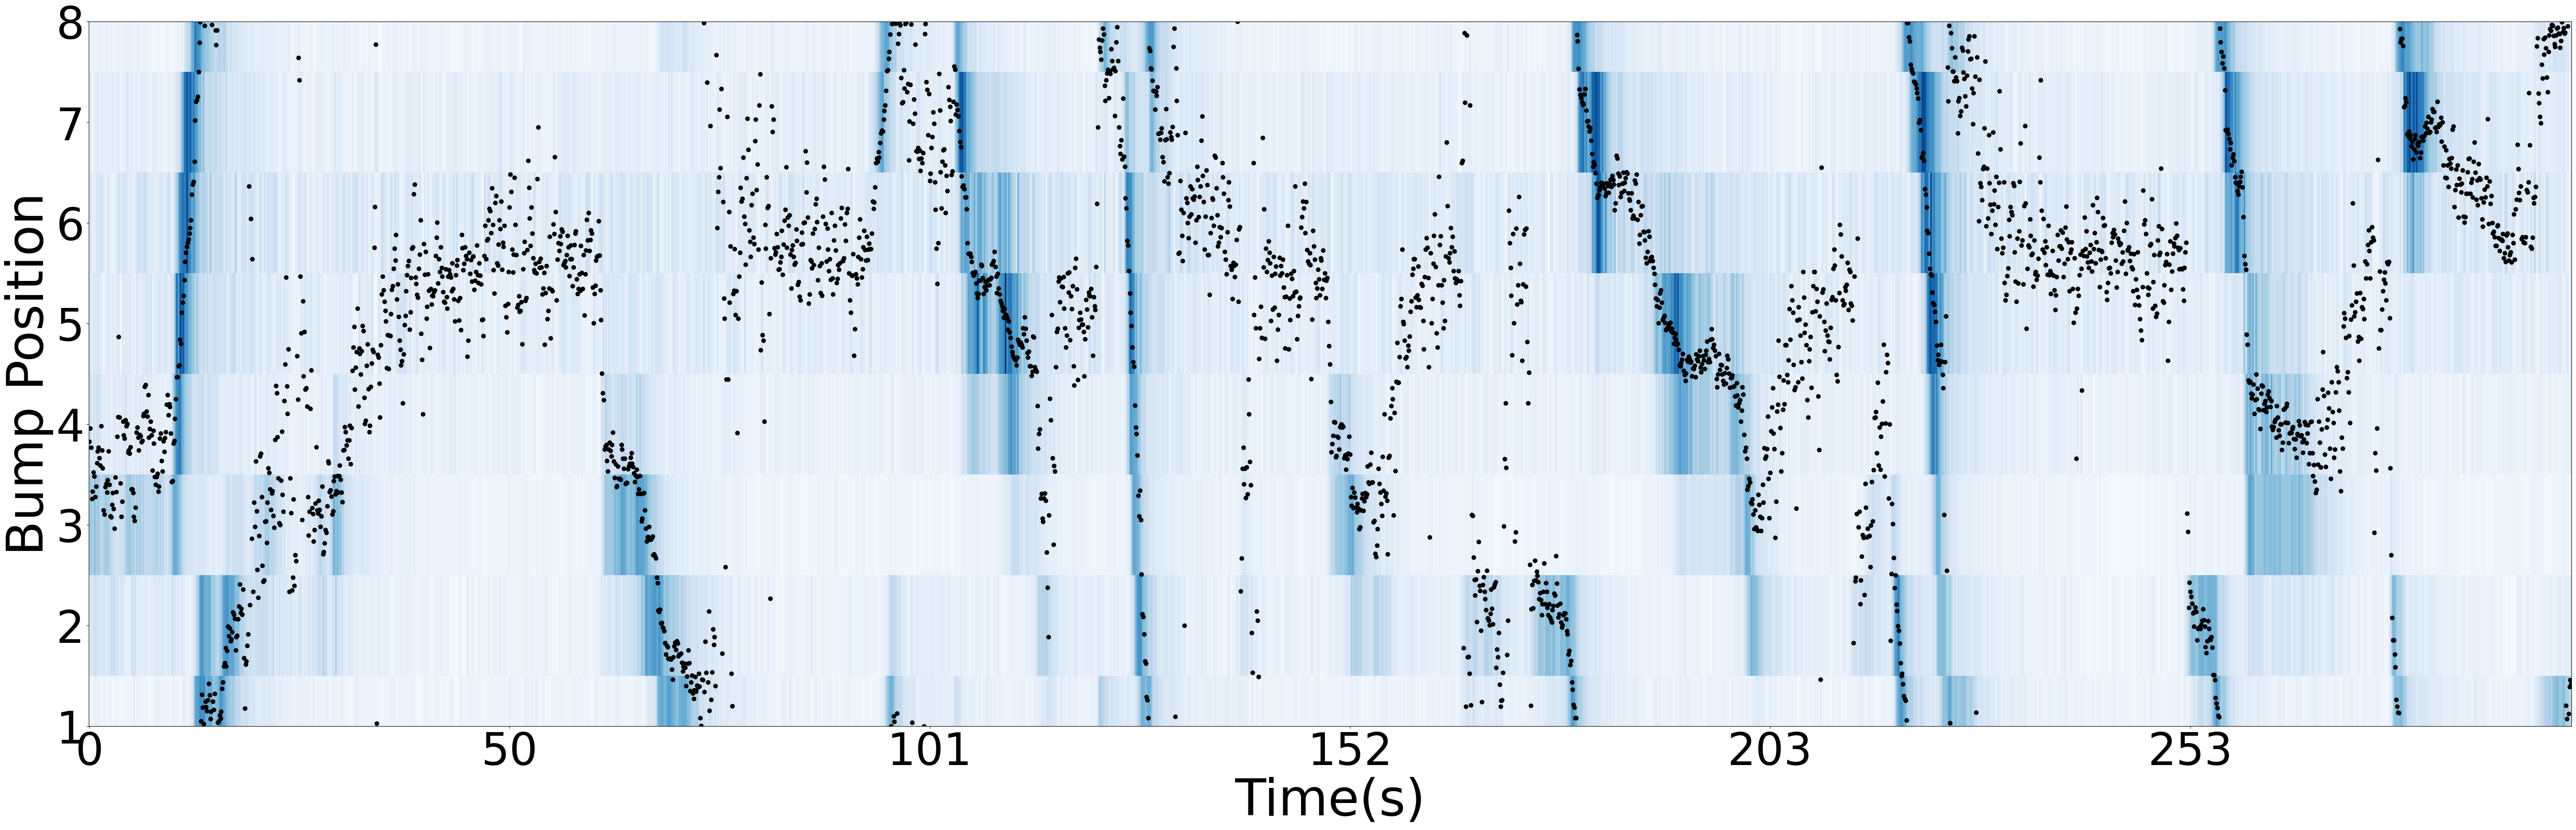

In [20]:
df_dff_in_ROI_normalized = dff_normalized_8_roi.transpose()
df_dff_in_ROI_normalized_shifted = np.zeros((np.size(df_dff_in_ROI_normalized,0),np.size(df_dff_in_ROI_normalized,1)))
df_dff_in_ROI_normalized_shifted[0,:] = df_dff_in_ROI_normalized[4,:]
df_dff_in_ROI_normalized_shifted[1,:] = df_dff_in_ROI_normalized[5,:]
df_dff_in_ROI_normalized_shifted[2,:] = df_dff_in_ROI_normalized[6,:]
df_dff_in_ROI_normalized_shifted[3,:] = df_dff_in_ROI_normalized[7,:] 
df_dff_in_ROI_normalized_shifted[4,:] = df_dff_in_ROI_normalized[0,:] 
df_dff_in_ROI_normalized_shifted[5,:] = df_dff_in_ROI_normalized[1,:] 
df_dff_in_ROI_normalized_shifted[6,:] = df_dff_in_ROI_normalized[2,:] 
df_dff_in_ROI_normalized_shifted[7,:] = df_dff_in_ROI_normalized[3,:] 
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues')
#plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle)),7*(PVA_Angle+180)/2/180, color ='black', s = 40)
plt.show()
#a.savefig('E-PG_Bump_Heatmap__dark', format ='svg')

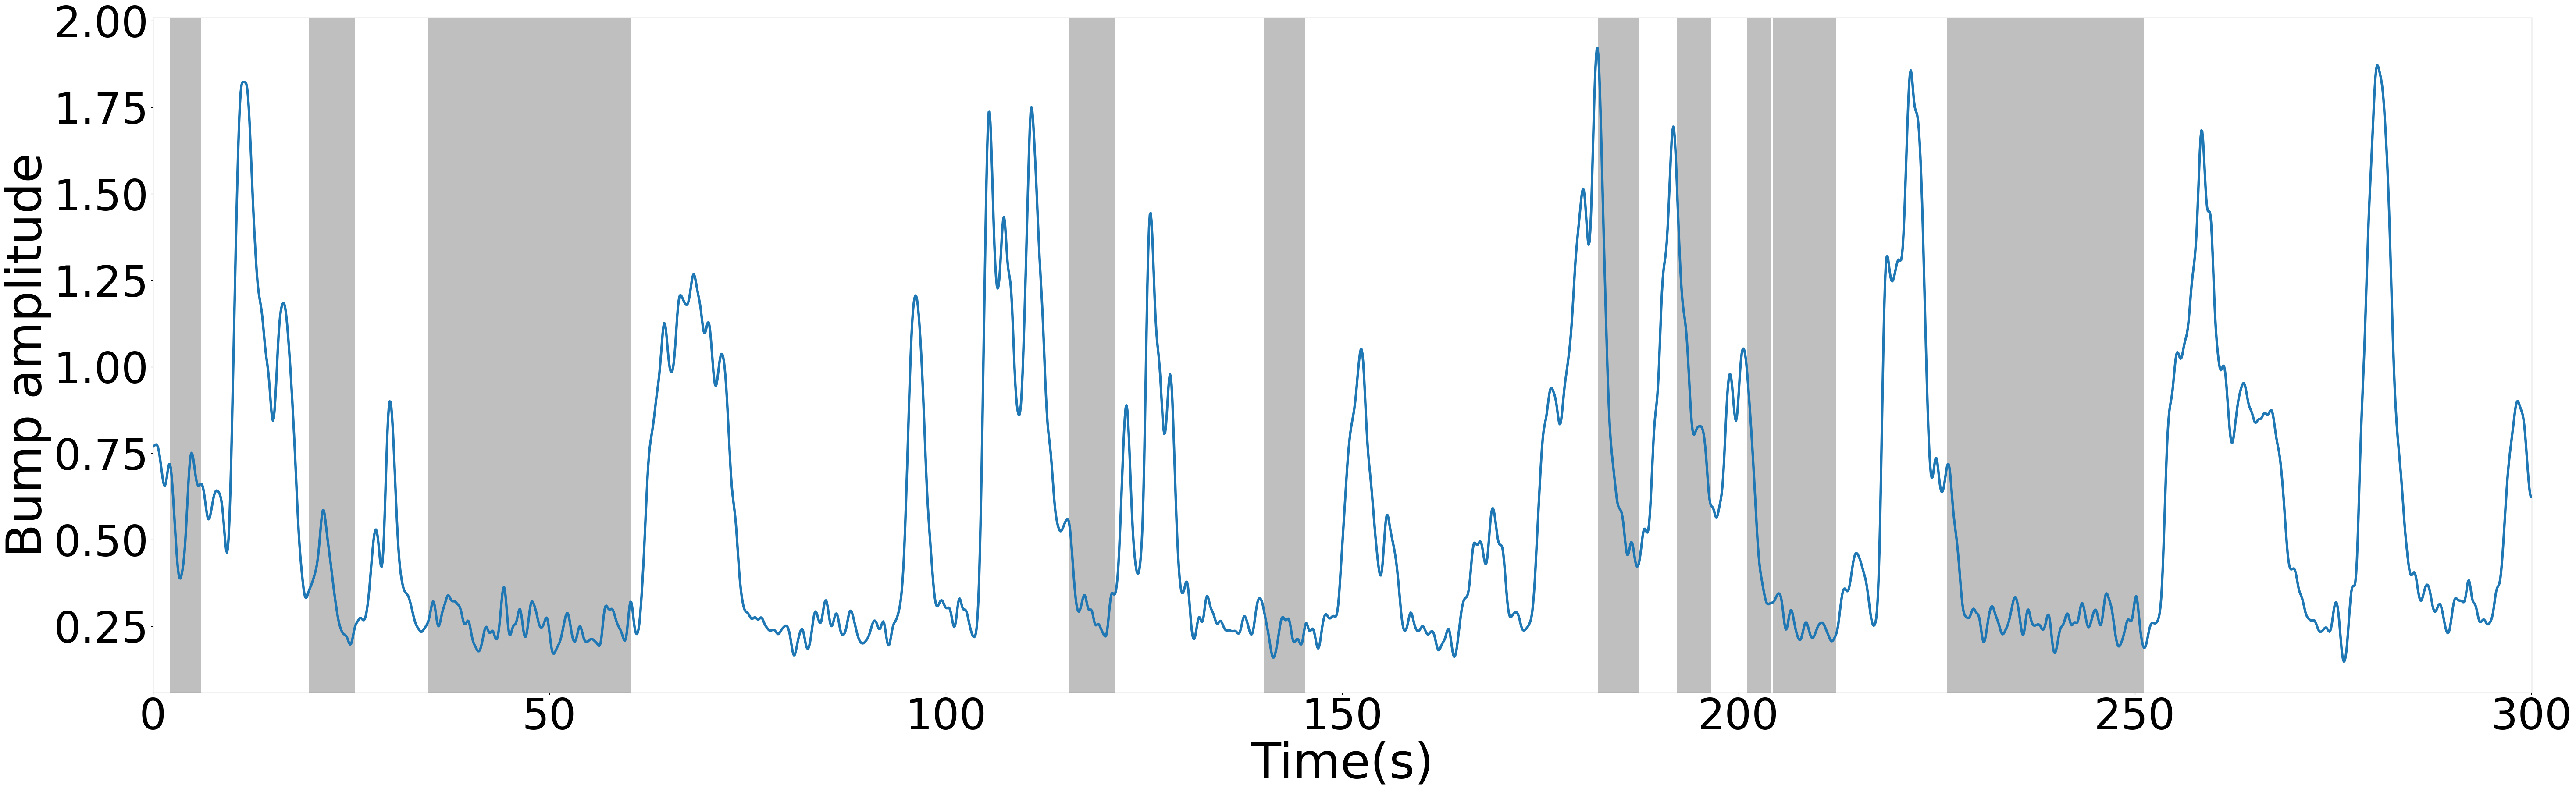

In [21]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(Bump_amplitude, sigma =3),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude', fontsize=80)
plt.show()

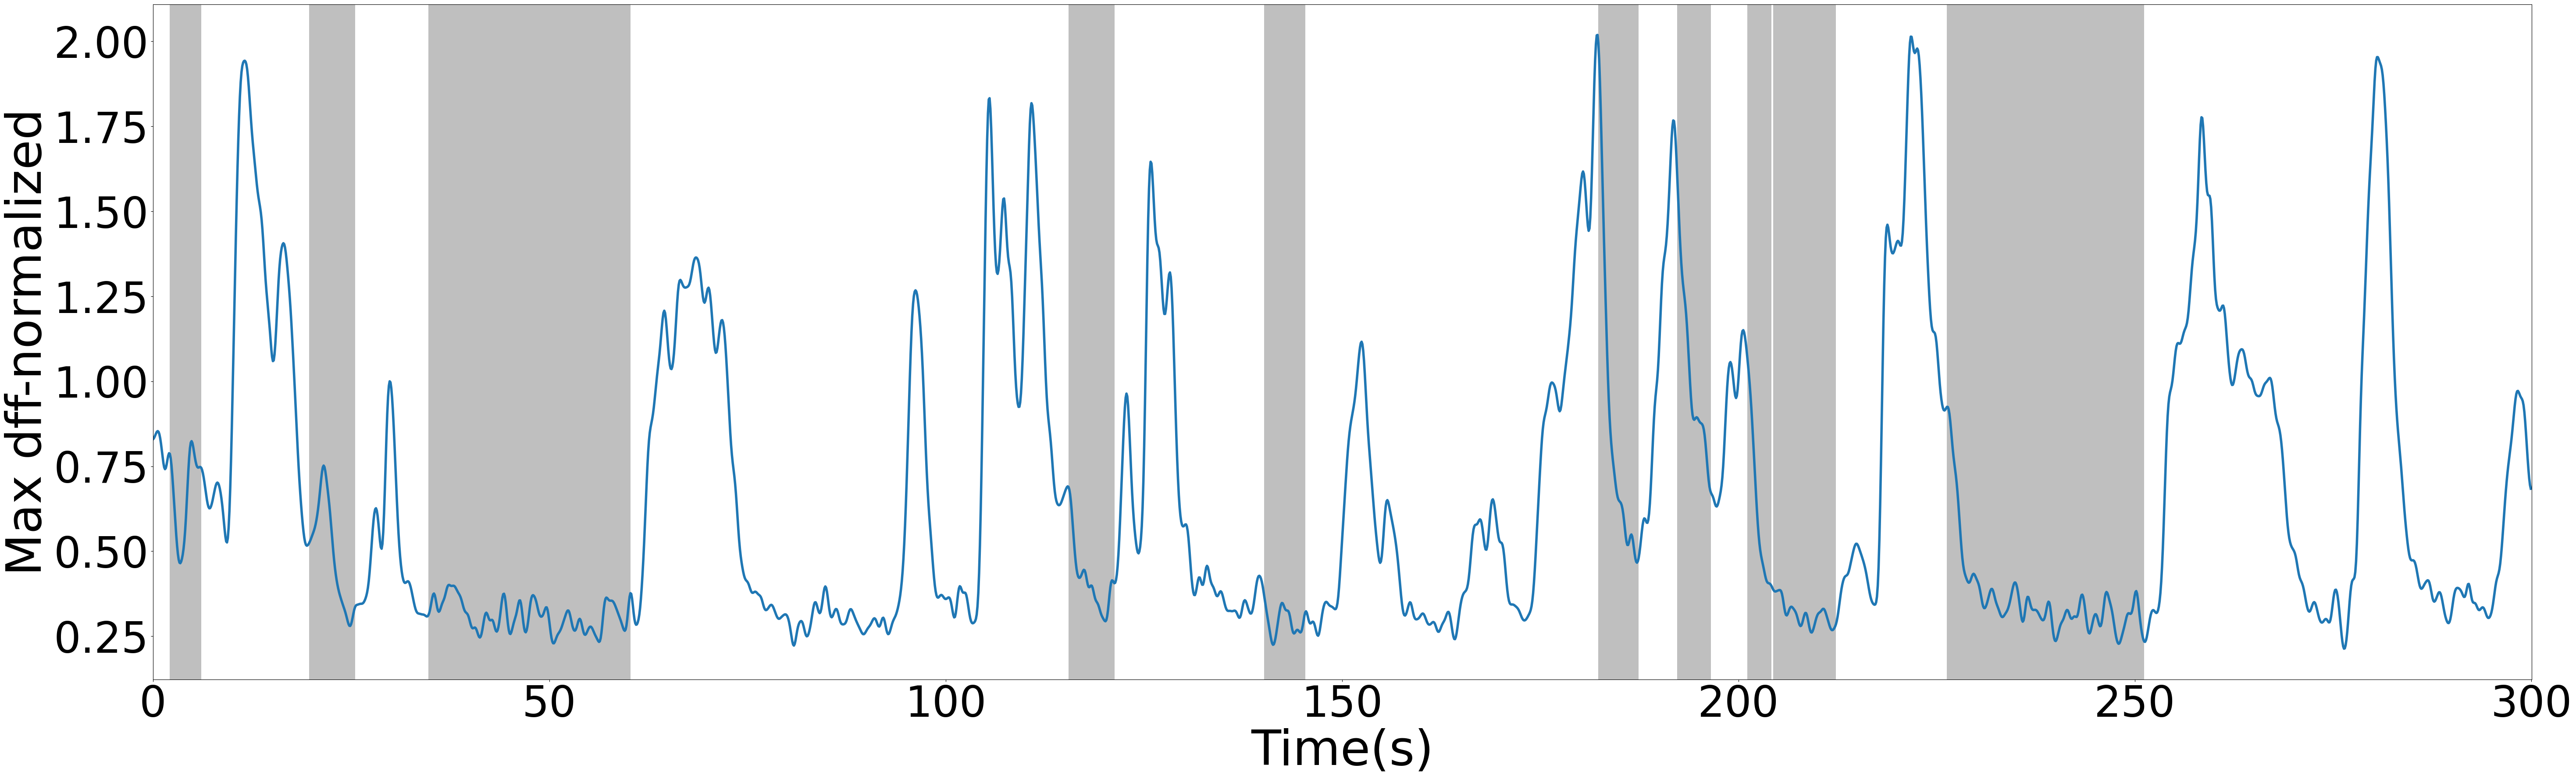

In [22]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(np.max(dff_normalized_8_roi,axis=1), sigma =3),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Max dff-normalized', fontsize=80)
plt.show()
plt.show()

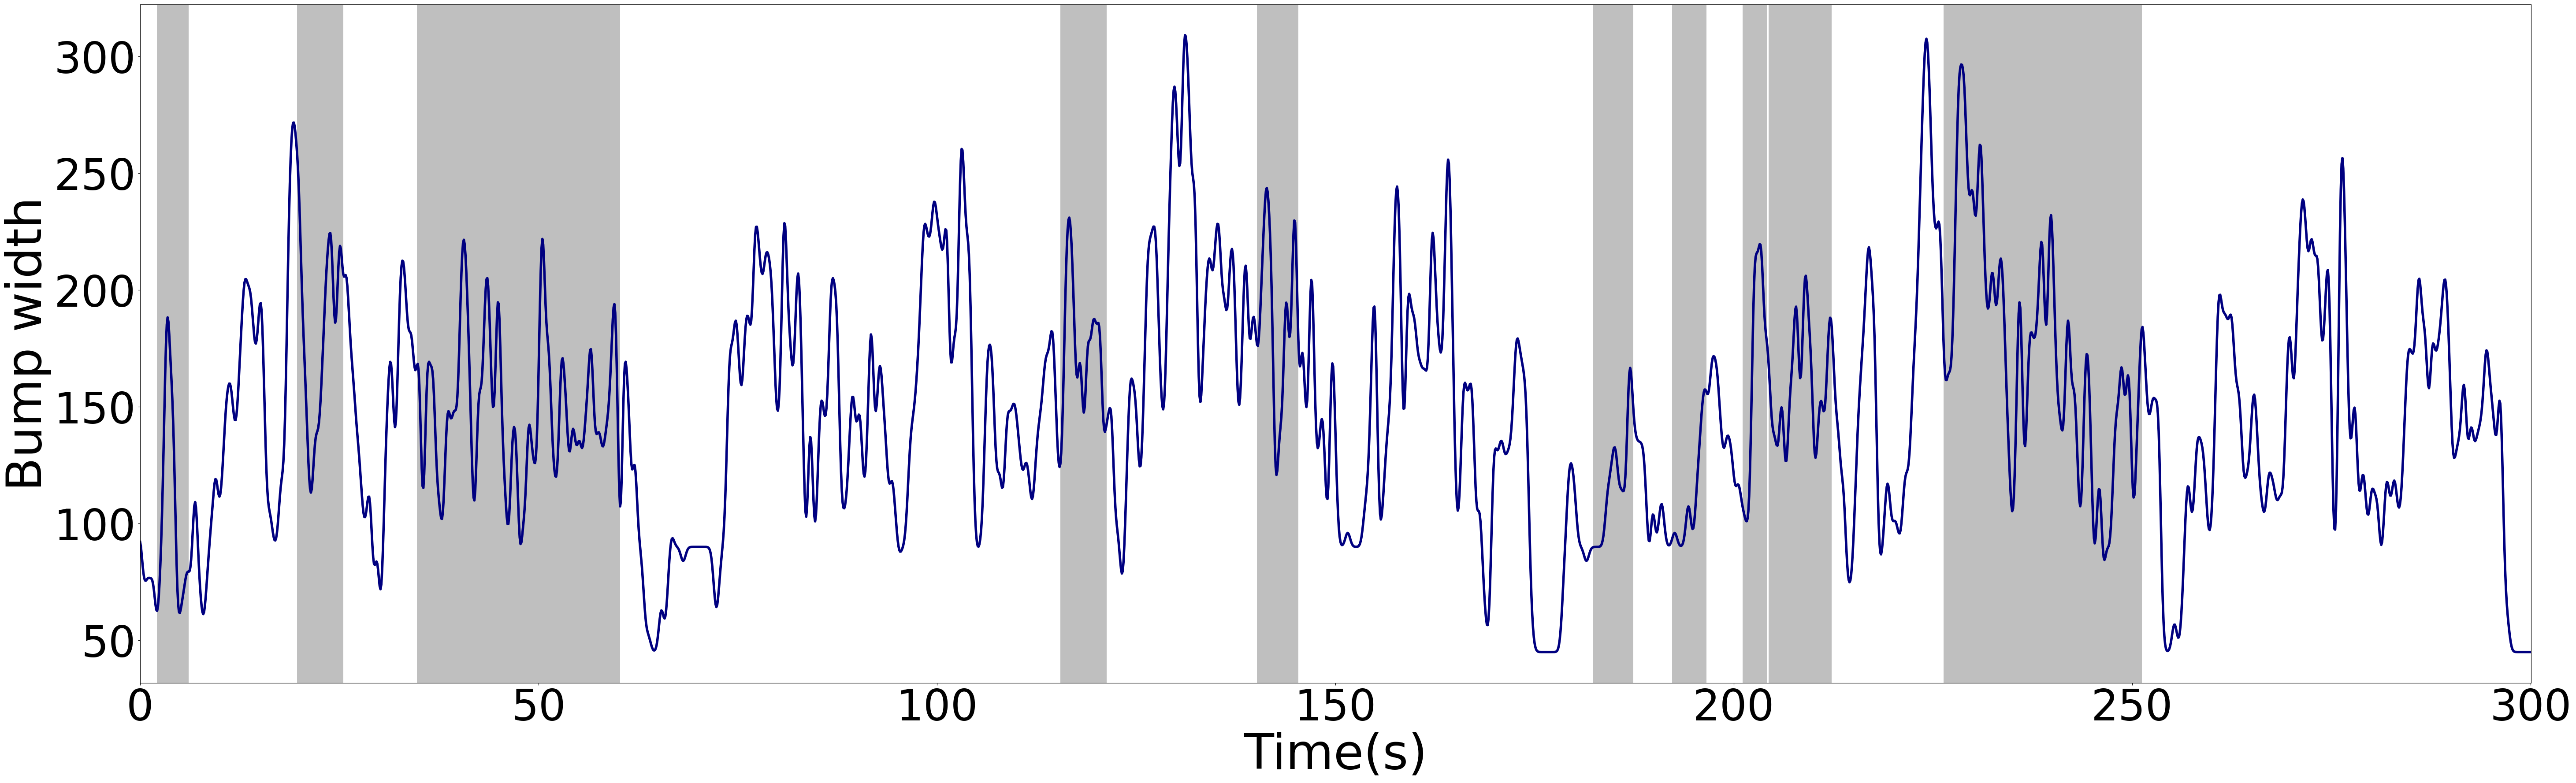

In [23]:
bump_width= calculateBumpWidth_v1(dff_normalized_8_roi,8)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_width, sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width', fontsize=80)
plt.show()
plt.show()

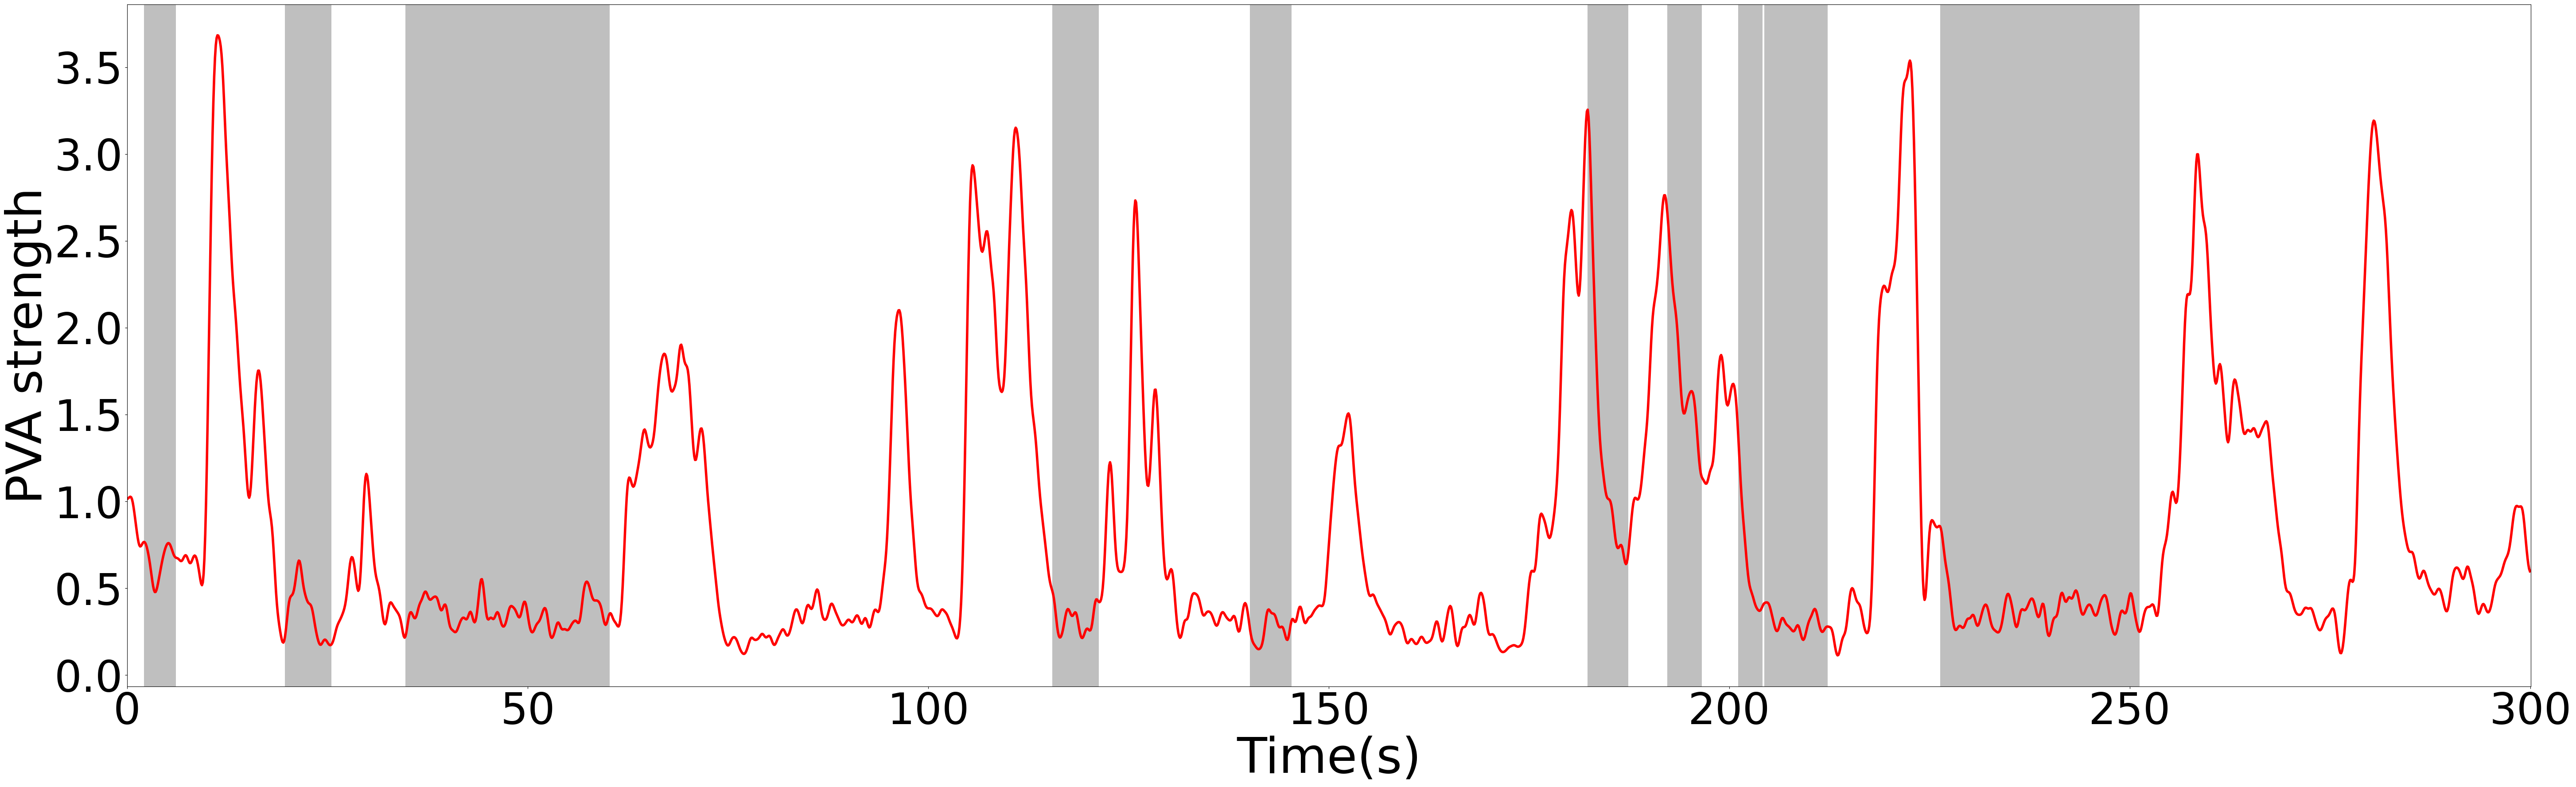

In [24]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(PVA_strength_no_series, sigma =3),color = 'r',linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('PVA strength', fontsize=80)
plt.show()

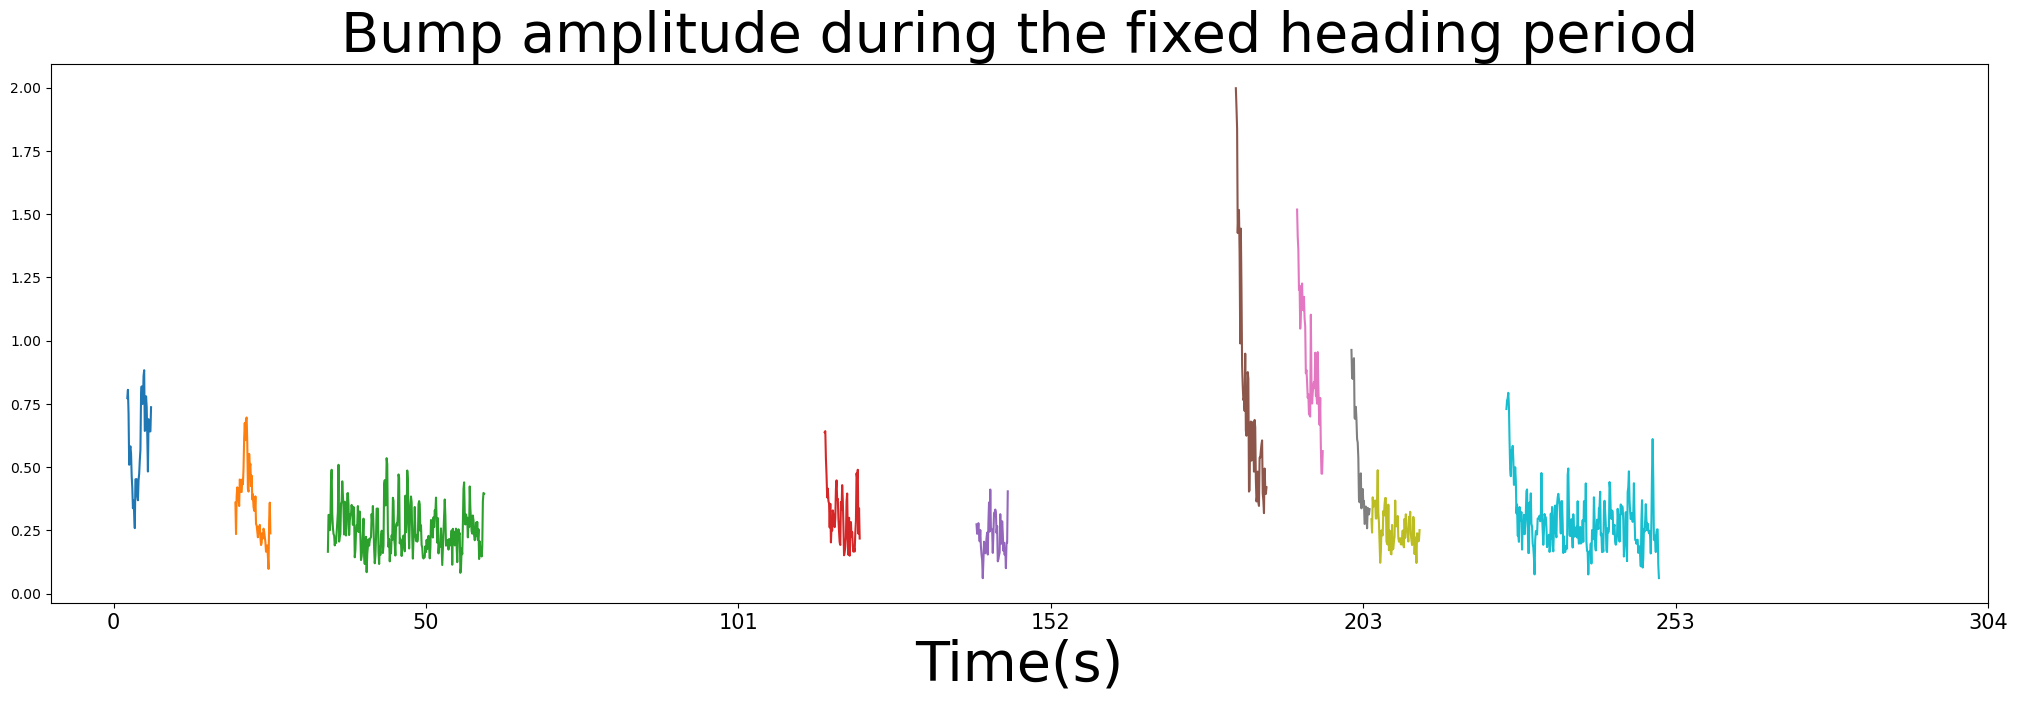

In [25]:
#Check bump amplitude during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Bump_amplitude[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

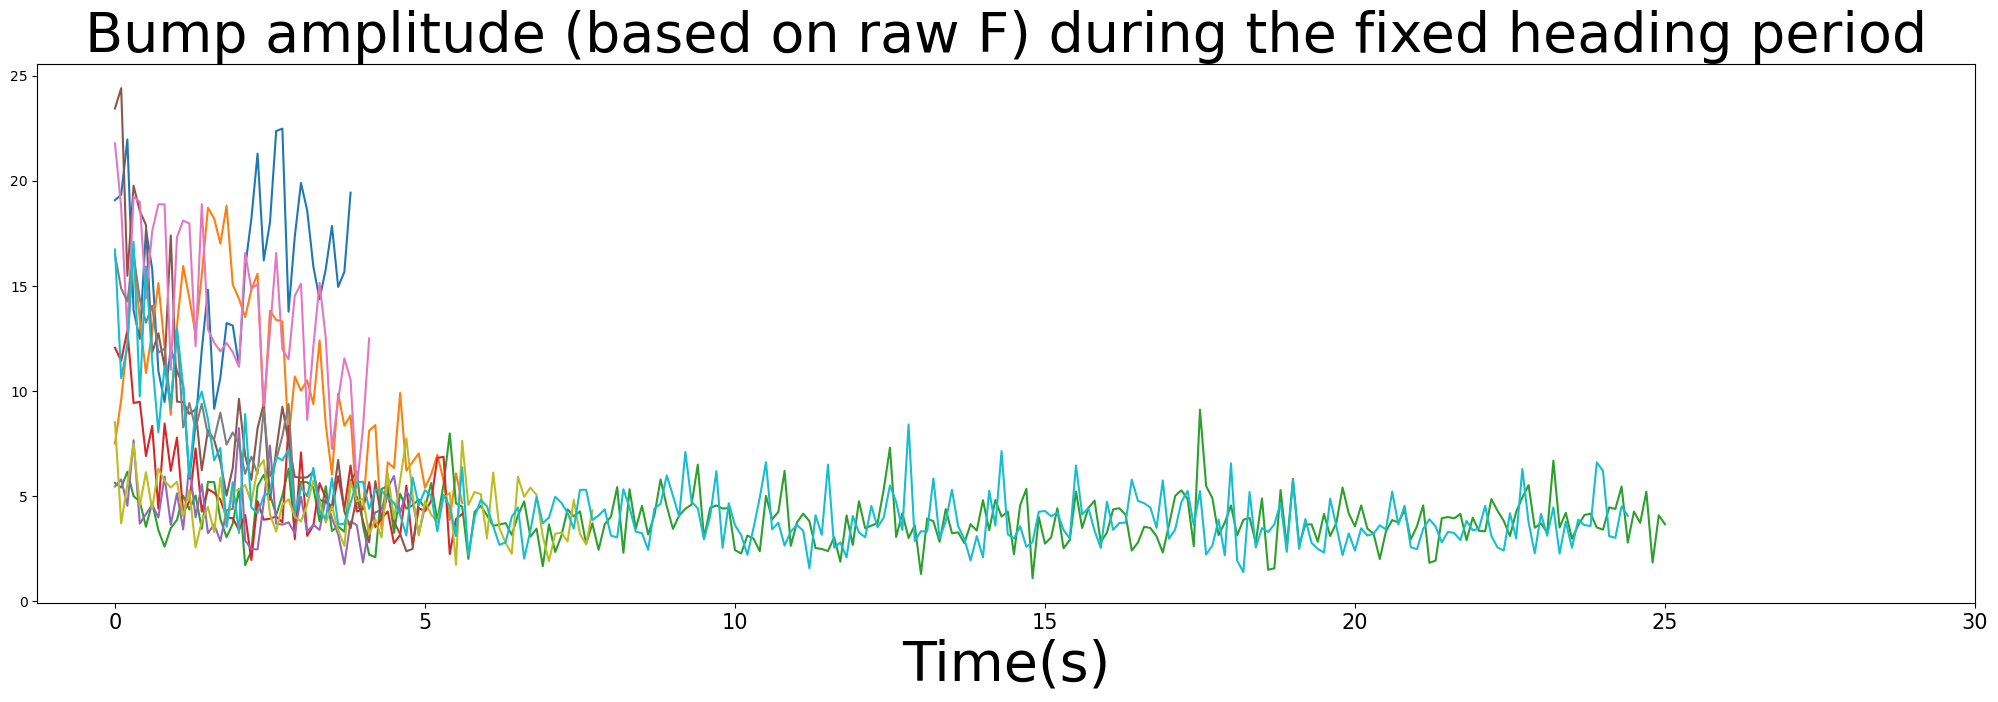

In [26]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(bump_amplitude_F[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude (based on raw F) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

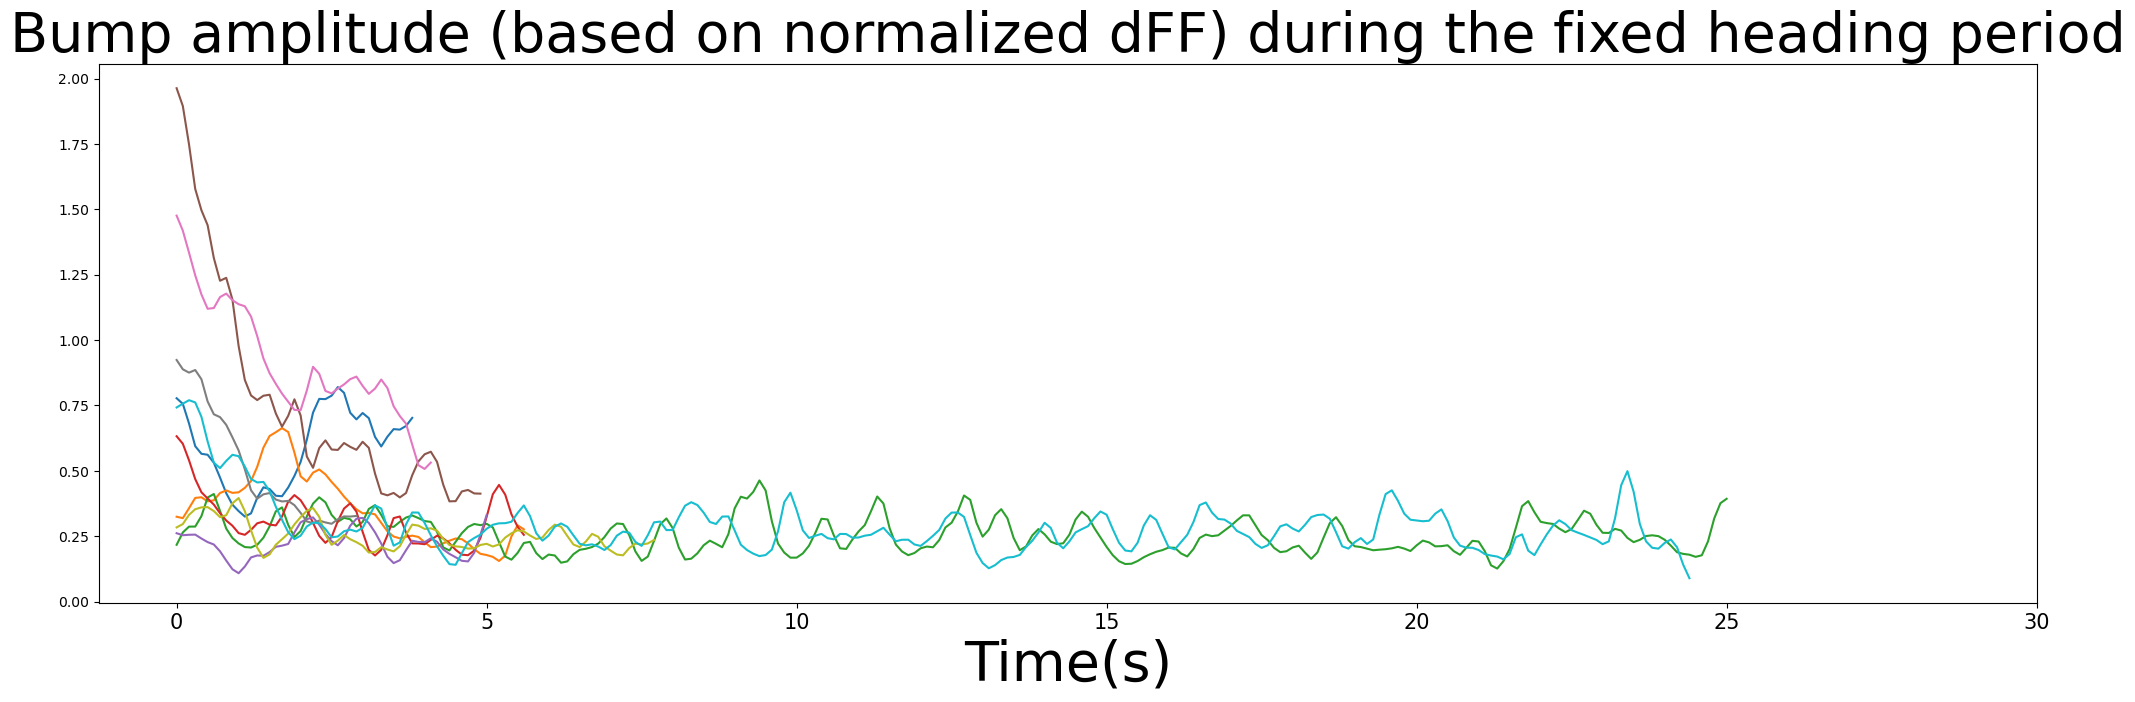

In [27]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(gaussian_filter1d(Bump_amplitude_no_series[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1],sigma =1))
plt.title('Bump amplitude (based on normalized dFF) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

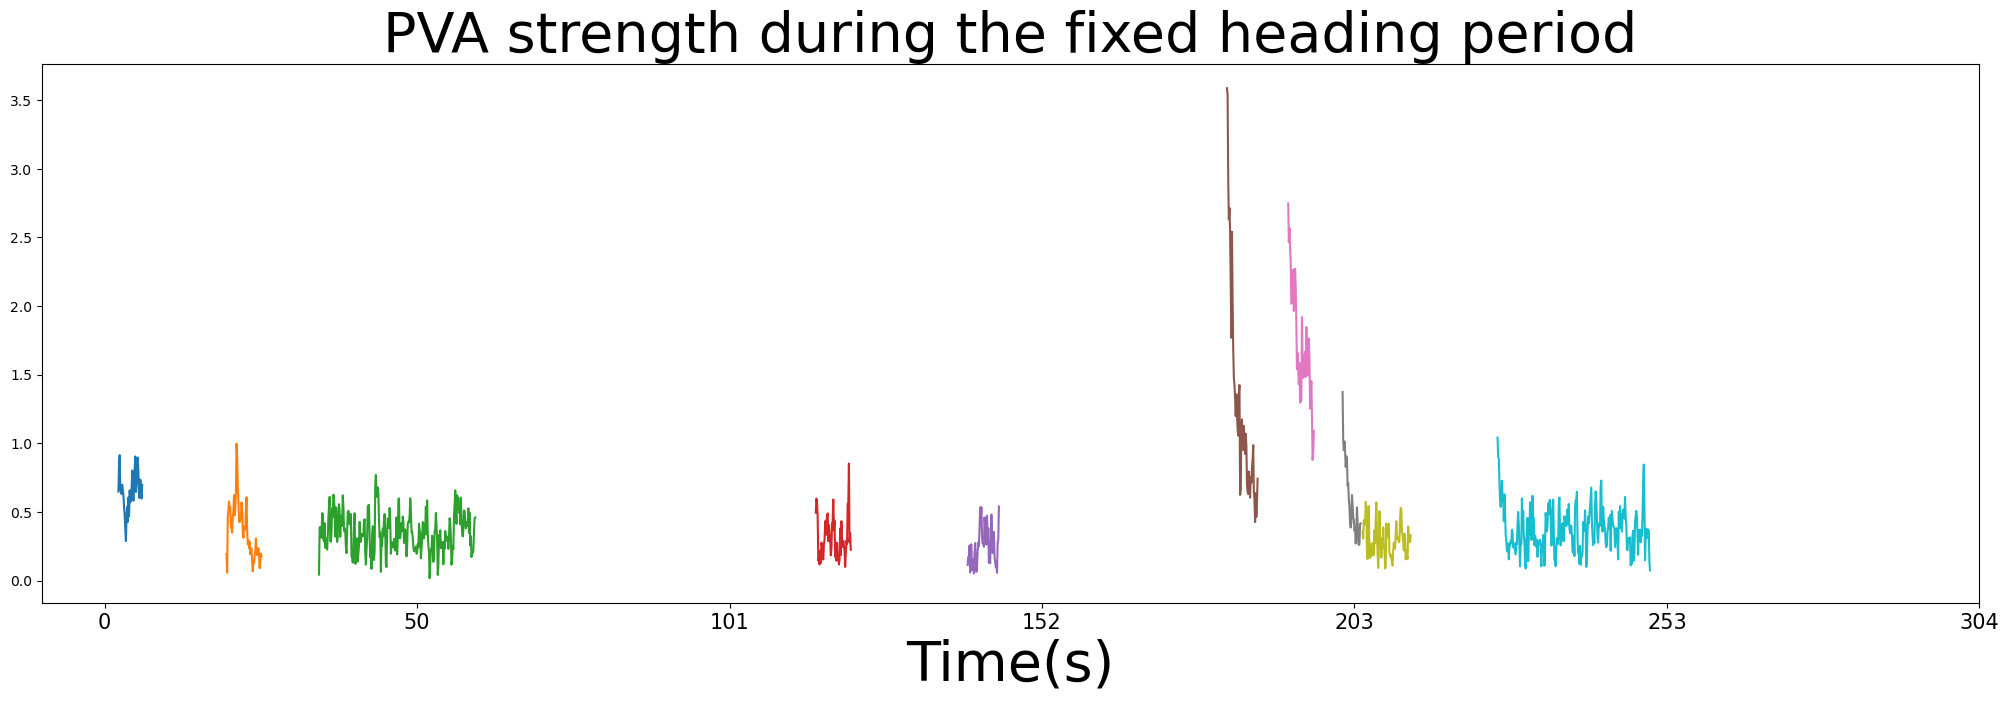

In [28]:
#Check PVA strength during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(PVA_strength[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.title('PVA strength during the fixed heading period', fontsize =40)
plt.xlabel('Time(s)', fontsize=40)
plt.show()
    

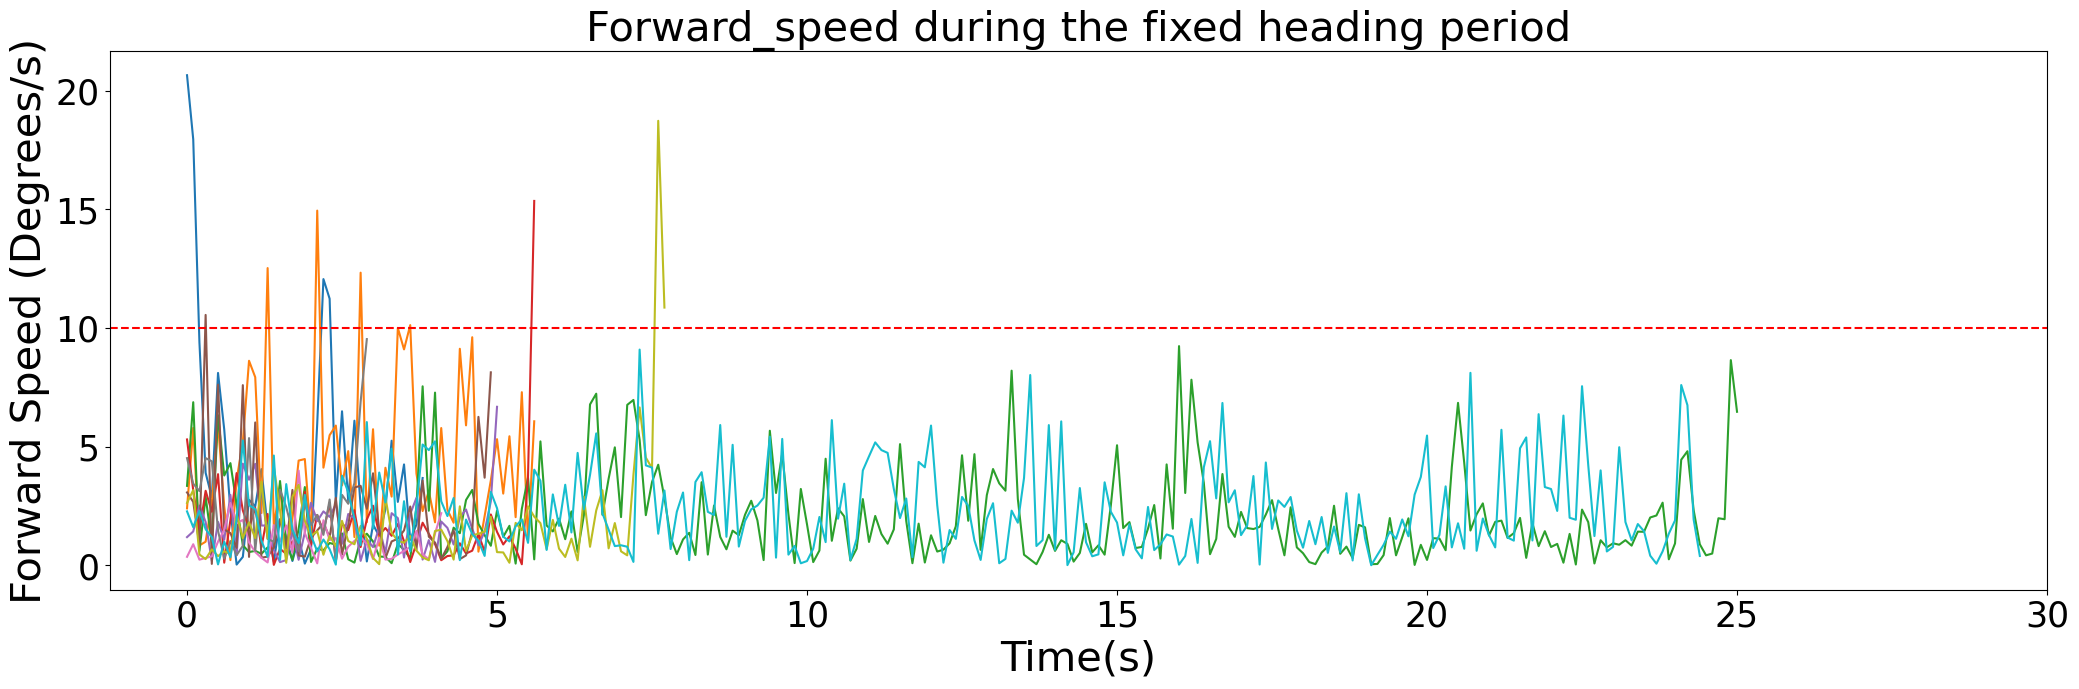

In [29]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

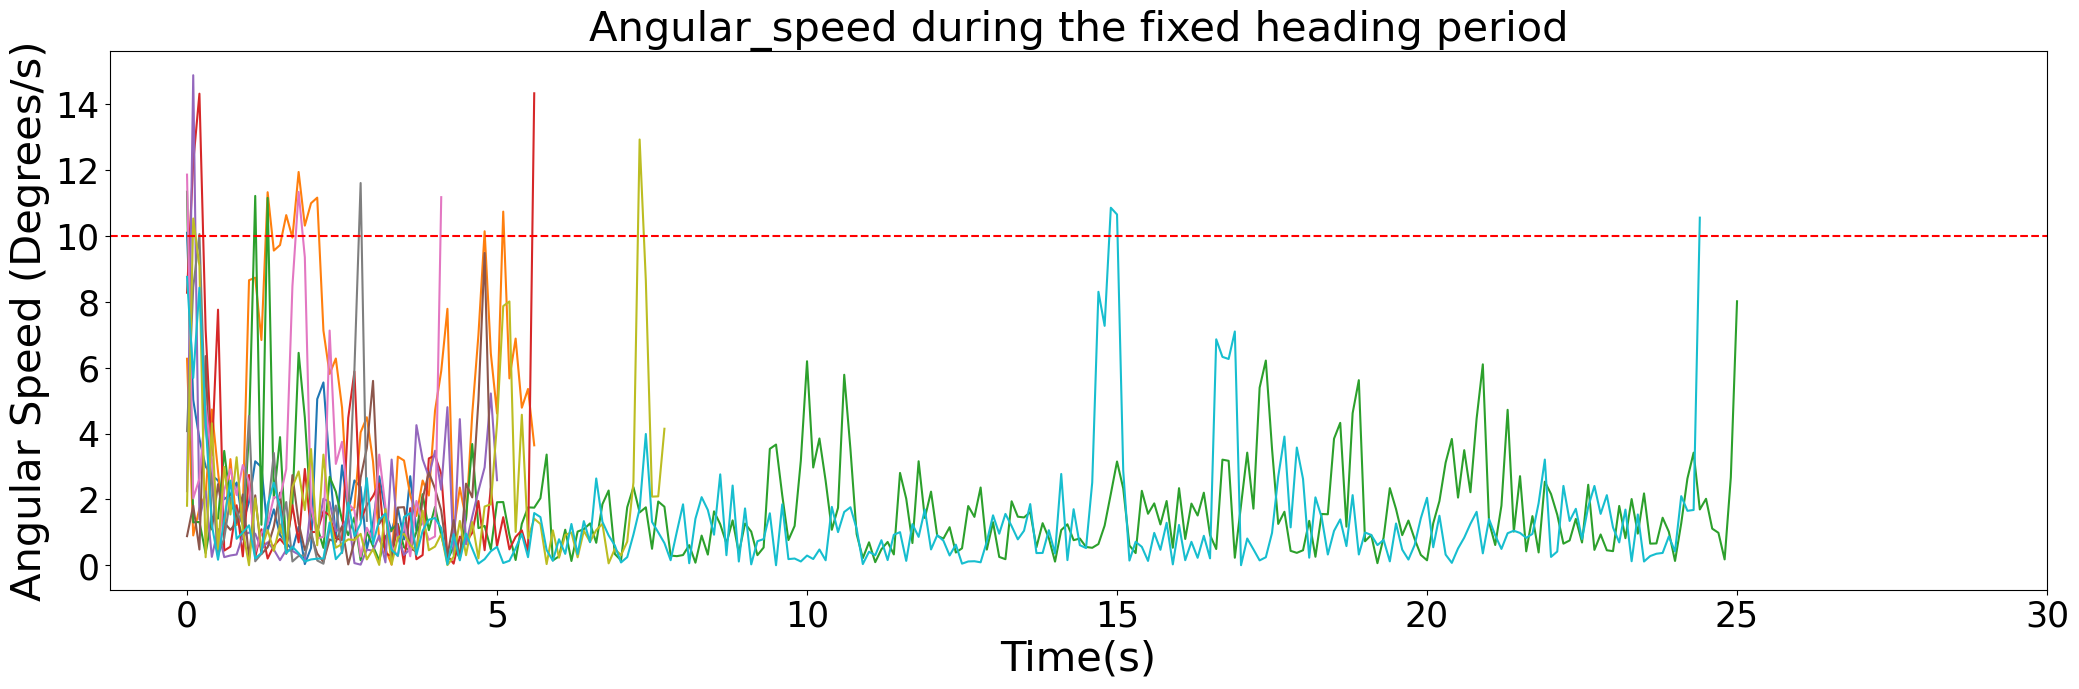

In [30]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

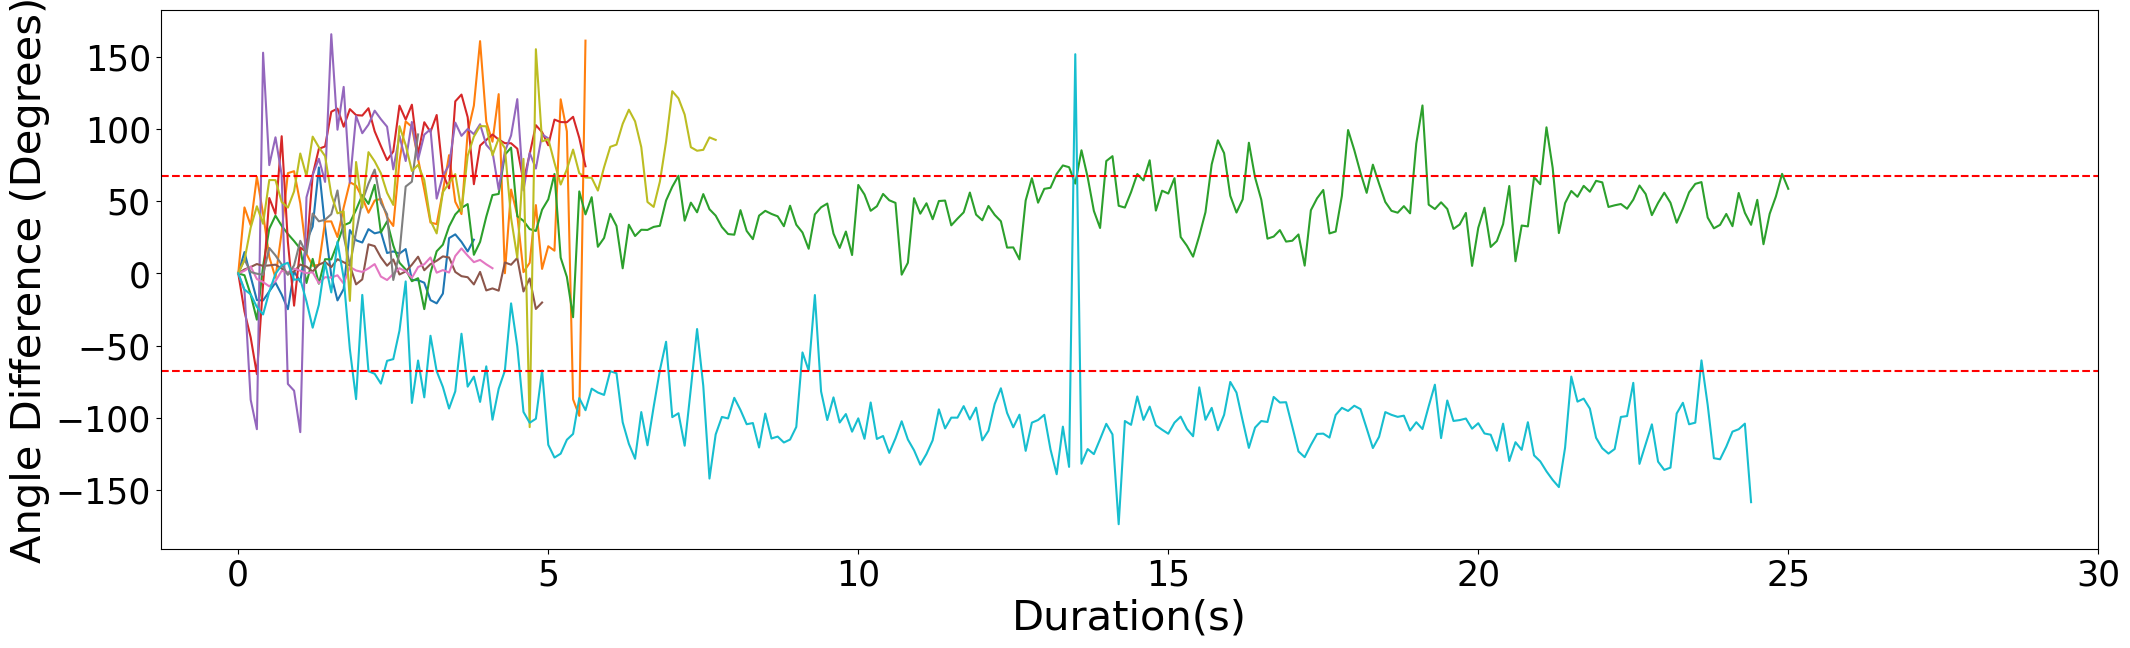

In [31]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

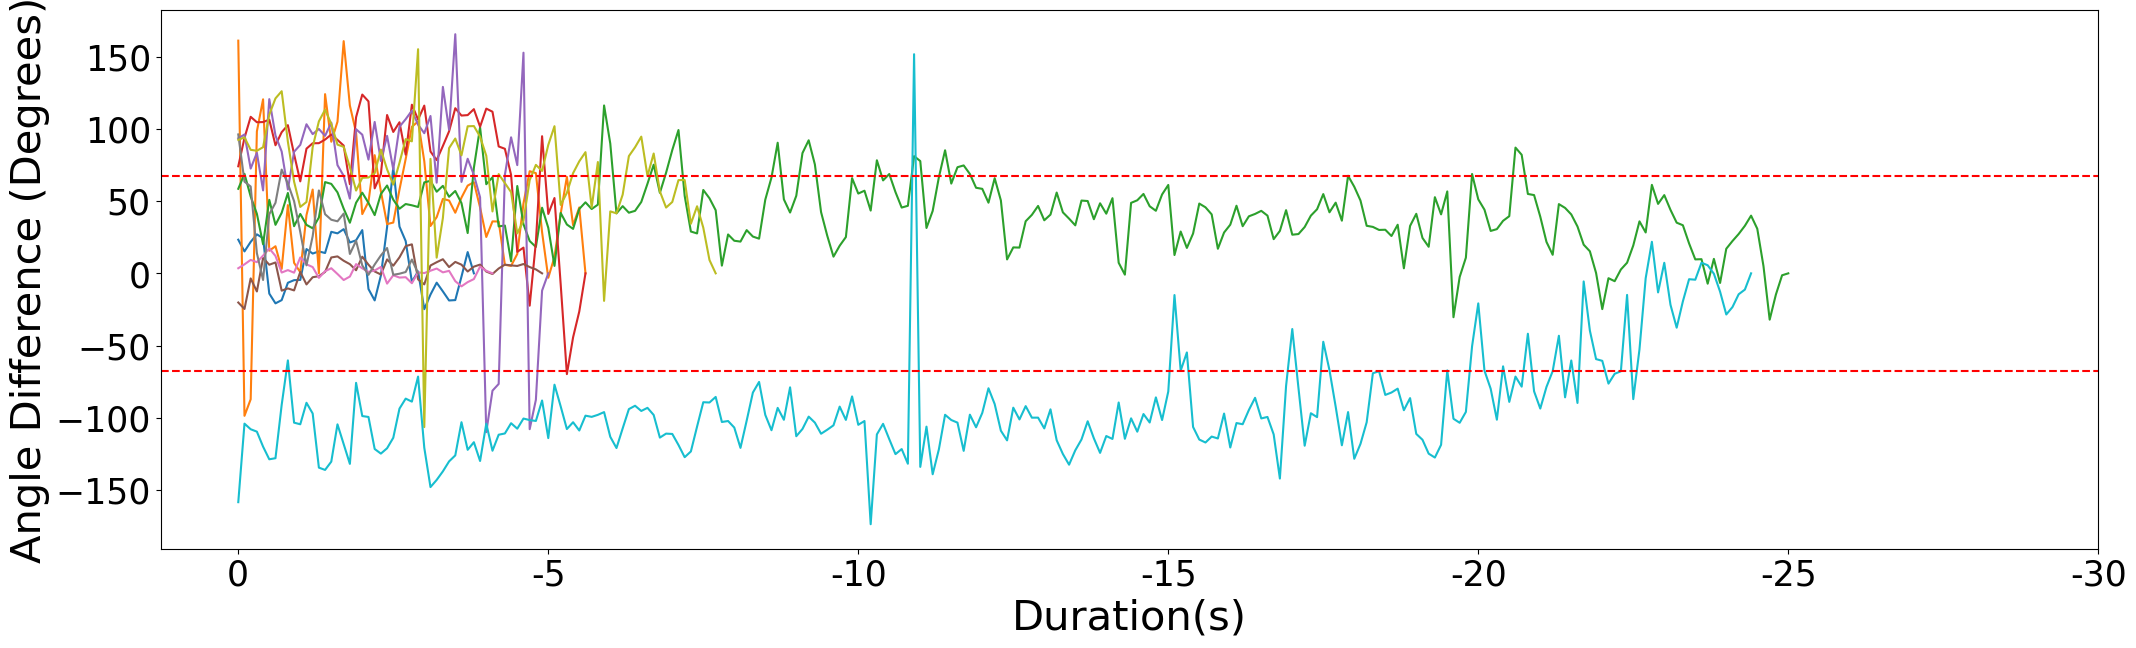

In [32]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [33]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly091-007')
PVA_angle_at_stop.insert(1,'Genotype','SS02191>sytGCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','dark')
PVA_angle_at_stop

FlyTrial            Genotype TrialType  Period_duration   
0  TQfly091-007  SS02191>sytGCaMP7f      dark          3.96123  \
1  TQfly091-007  SS02191>sytGCaMP7f      dark          5.78949   
2  TQfly091-007  SS02191>sytGCaMP7f      dark         25.49407   
3  TQfly091-007  SS02191>sytGCaMP7f      dark          5.78949   
4  TQfly091-007  SS02191>sytGCaMP7f      dark          5.18007   
5  TQfly091-007  SS02191>sytGCaMP7f      dark          5.07850   
6  TQfly091-007  SS02191>sytGCaMP7f      dark          4.26594   
7  TQfly091-007  SS02191>sytGCaMP7f      dark          3.04710   
8  TQfly091-007  SS02191>sytGCaMP7f      dark          7.92246   
9  TQfly091-007  SS02191>sytGCaMP7f      dark         24.88465   

   PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0       -54.365697      -31.084024                -39.190823  \
1      -111.381267       49.661122                150.002531   
2         9.747782       68.263999                 78.612035   
3       -64.813069        9.285073                 28.891355   
4       -44.900569       48.536196                 51.200959   
5        91.291456       71.108066                 66.641629   
6         5.520406        9.052154                 11.745631   
7       -79.225568       16.910562                -15.767830   
8       -49.815343       42.531272                 44.278470   
9       165.127278        6.763613                 61.106081   

   PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart   
0                -29.986044     -31.493708             -31.493708  \
1                  9.058725      -9.968085             -13.917630   
2                 29.891058      27.695256              58.604369   
3                 39.884832      51.903074              43.245827   
4                 12.495523      27.077613              54.843462   
5                101.931148      96.569669              93.438656   
6                 17.775493       6.498196              11.918365   
7                -83.810994     -42.131693             -56.710170   
8                 37.477529      44.790544               7.462208   
9                 45.193306      74.664520              89.344494   

   PVA_3s_after_stop  PVA_5s_after_stop  PVA_10s_after_stop   
0         -59.081867                NaN                 NaN  \
1         -32.236724        -108.320595                 NaN   
2           6.391309          53.788843           38.678414   
3          17.338715          32.879262                 NaN   
4          33.820204          51.200959                 NaN   
5         102.808814          71.108066                 NaN   
6           9.853833                NaN                 NaN   
7          16.910562                NaN                 NaN   
8          25.246629          41.536693                 NaN   
9         104.806029          97.947190           67.755923   

   PVA_35s_after_stop  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
5                 NaN  
6                 NaN  
7                 NaN  
8                 NaN  
9                 NaN

In [34]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart   
0                  20.659667                  3.680742  \
1                   2.400523                  6.071341   
2                   3.349897                  6.472483   
3                   5.305522                 15.360319   
4                   1.188181                  6.682335   
5                   3.073337                  8.134735   
6                   0.358689                  2.198360   
7                   4.518998                  9.535997   
8                   2.627045                 10.864880   
9                   2.274098                  0.395356   

   forward_speed_100ms_before_restart  forward_speed_500ms_before_restart   
0                            1.713589                            2.674136  \
1                            1.006233                            5.441018   
2                            8.650407                            0.496403   
3                            3.762160                            1.224568   
4                            2.698231                            1.537543   
5                            3.693563                            0.417659   
6                            1.340462                            1.451294   
7                            6.894413                            2.970066   
8                           18.738318                            6.656363   
9                            1.935807                            1.893052   

   forward_speed_in_middle  forward_speed_2s_before_restart   
0                 0.071760                         0.071760  \
1                12.336409                         3.868710   
2                 4.638228                         0.868670   
3                 0.767948                         0.915497   
4                 0.905238                         1.601470   
5                 2.843027                         3.879158   
6                 0.724720                         1.901759   
7                 0.993254                         5.363621   
8                 0.331608                         0.682105   
9                 0.112018                         7.550922   

   forward_speed_3s_after_stop  forward_speed_5s_after_stop   
0                     0.163259                          NaN  \
1                     1.816727                     3.579811   
2                     1.332764                     0.824284   
3                     1.934477                     2.144662   
4                     1.104790                     2.698231   
5                     2.383995                     8.134735   
6                     0.892552                          NaN   
7                     9.535997                          NaN   
8                     1.115220                     2.046262   
9                     6.038510                     3.095717   

   forward_speed_10s_after_stop  forward_speed_35s_after_stop  
0                           NaN                           NaN  
1                           NaN                           NaN  
2                      0.094968                           NaN  
3                           NaN                           NaN  
4                           NaN                           NaN  
5                           NaN                           NaN  
6                           NaN                           NaN  
7                           NaN                           NaN  
8                           NaN                           NaN  
9                      0.818149                           NaN

In [35]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart   
0                    0.772672                   0.736715  \
1                    0.359645                   0.238044   
2                    0.165320                   0.395176   
3                    0.638186                   0.217663   
4                    0.273837                   0.404228   
5                    1.997780                   0.420229   
6                    1.518214                   0.563203   
7                    0.963211                   0.333801   
8                    0.294210                   0.250943   
9                    0.729584                   0.061280   

   bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                             0.641187                             0.689367  \
1                             0.359532                             0.145297   
2                             0.397843                             0.146508   
3                             0.337095                             0.456039   
4                             0.201154                             0.178544   
5                             0.393828                             0.318098   
6                             0.473642                             0.773336   
7                             0.312874                             0.258059   
8                             0.209098                             0.238284   
9                             0.115605                             0.242351   

   bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                  0.473466                          0.473466  \
1                  0.393030                          0.263050   
2                  0.242130                          0.236870   
3                  0.428703                          0.235311   
4                  0.252315                          0.322264   
5                  0.680157                          0.686431   
6                  0.705335                          1.102467   
7                  0.414416                          0.597018   
8                  0.367768                          0.237510   
9                  0.290182                          0.250390   

   bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop   
0                      0.647414                           NaN  \
1                      0.343157                      0.165637   
2                      0.229610                      0.243325   
3                      0.369681                      0.239228   
4                      0.319706                      0.201154   
5                      0.482032                      0.420229   
6                      0.952109                           NaN   
7                      0.333801                           NaN   
8                      0.248996                      0.217337   
9                      0.234601                      0.233808   

   bump_amplitude_10s_after_stop  bump_amplitude_35s_after_stop  
0                            NaN                            NaN  
1                            NaN                            NaN  
2                       0.215929                            NaN  
3                            NaN                            NaN  
4                            NaN                            NaN  
5                            NaN                            NaN  
6                            NaN                            NaN  
7                            NaN                            NaN  
8                            NaN                            NaN  
9                       0.468671                            NaN

In [36]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial            Genotype TrialType  Period_duration   
0  TQfly091-007  SS02191>sytGCaMP7f      dark          3.96123  \
1  TQfly091-007  SS02191>sytGCaMP7f      dark          5.78949   
2  TQfly091-007  SS02191>sytGCaMP7f      dark         25.49407   
3  TQfly091-007  SS02191>sytGCaMP7f      dark          5.78949   
4  TQfly091-007  SS02191>sytGCaMP7f      dark          5.18007   
5  TQfly091-007  SS02191>sytGCaMP7f      dark          5.07850   
6  TQfly091-007  SS02191>sytGCaMP7f      dark          4.26594   
7  TQfly091-007  SS02191>sytGCaMP7f      dark          3.04710   
8  TQfly091-007  SS02191>sytGCaMP7f      dark          7.92246   
9  TQfly091-007  SS02191>sytGCaMP7f      dark         24.88465   

   PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0       -54.365697      -31.084024                -39.190823  \
1      -111.381267       49.661122                150.002531   
2         9.747782       68.263999                 78.612035   
3       -64.813069        9.285073                 28.891355   
4       -44.900569       48.536196                 51.200959   
5        91.291456       71.108066                 66.641629   
6         5.520406        9.052154                 11.745631   
7       -79.225568       16.910562                -15.767830   
8       -49.815343       42.531272                 44.278470   
9       165.127278        6.763613                 61.106081   

   PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                -29.986044     -31.493708             -31.493708  ...  \
1                  9.058725      -9.968085             -13.917630  ...   
2                 29.891058      27.695256              58.604369  ...   
3                 39.884832      51.903074              43.245827  ...   
4                 12.495523      27.077613              54.843462  ...   
5                101.931148      96.569669              93.438656  ...   
6                 17.775493       6.498196              11.918365  ...   
7                -83.810994     -42.131693             -56.710170  ...   
8                 37.477529      44.790544               7.462208  ...   
9                 45.193306      74.664520              89.344494  ...   

   bump_amplitude_before_stop  bump_amplitude_at_restart   
0                    0.772672                   0.736715  \
1                    0.359645                   0.238044   
2                    0.165320                   0.395176   
3                    0.638186                   0.217663   
4                    0.273837                   0.404228   
5                    1.997780                   0.420229   
6                    1.518214                   0.563203   
7                    0.963211                   0.333801   
8                    0.294210                   0.250943   
9                    0.729584                   0.061280   

   bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                             0.641187                             0.689367  \
1                             0.359532                             0.145297   
2                             0.397843                             0.146508   
3                             0.337095                             0.456039   
4                             0.201154                             0.178544   
5                             0.393828                             0.318098   
6                             0.473642                             0.773336   
7                             0.312874                             0.258059   
8                             0.209098                             0.238284   
9                             0.115605                             0.242351   

   bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                  0.473466                          0.473466  \
1                  0.393030                          0.263050   
2                  0.242130       

In [37]:
output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/PEG_EB(syt)/TQfly091-007-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [38]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/PEG_EB(syt)')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial            Genotype TrialType  Period_duration   
0    TQfly090-001  SS02191>sytGCaMP7f      dark         10.15680  \
1    TQfly090-001  SS02191>sytGCaMP7f      dark          7.72340   
2    TQfly090-001  SS02191>sytGCaMP7f      dark          6.34800   
3    TQfly090-001  SS02191>sytGCaMP7f      dark          5.92480   
4    TQfly090-001  SS02191>sytGCaMP7f      dark          5.07840   
..            ...                 ...       ...              ...   
150  TQfly085-004  SS02191>sytGCaMP7f      dark          3.03960   
151  TQfly085-004  SS02191>sytGCaMP7f      dark          4.35676   
152  TQfly085-004  SS02191>sytGCaMP7f      dark          5.16732   
153  TQfly085-004  SS02191>sytGCaMP7f      dark          7.90296   
154  TQfly085-004  SS02191>sytGCaMP7f      dark          5.97788   

     PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         176.316166       25.751510                  9.242718  \
1        -114.253554        3.390949                  2.964930   
2         -18.694306       -9.929392                -12.272664   
3          46.846866       16.934298                 22.037675   
4          71.408245       30.503719                 47.012711   
..               ...             ...                       ...   
150        86.953716       53.052806                 46.593879   
151       114.226468       87.178652                 90.233883   
152        88.316304       74.358386                 78.777070   
153       144.824163      158.714602                 23.812635   
154       -51.737297       36.960083                113.189976   

     PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                   59.820526     -54.407736              45.222149  ...  \
1                    2.895906     -12.991694               8.707262  ...   
2                   -0.935360      11.836492               0.857346  ...   
3                   18.794655      26.027019              35.794010  ...   
4                   42.125314      59.236558              68.671096  ...   
..                        ...            ...                    ...  ...   
150                 50.254994      57.726829              49.543665  ...   
151                 89.149526      97.609400             100.241879  ...   
152                 51.019775      81.563953              49.242236  ...   
153                135.876297      79.744268              57.333679  ...   
154                 36.556190      93.936598              95.535271  ...   

     bump_amplitude_before_stop  bump_amplitude_at_restart   
0                      1.058634                   0.428294  \
1                      0.468963                   0.312200   
2                      0.261346                   0.309101   
3                      0.995435                   0.536664   
4                      0.768323                   0.378115   
..                          ...                        ...   
150                    0.348976                   0.339605   
151                    2.963343                   0.708179   
152                    0.431146                   0.215016   
153                    0.231317                   0.189758   
154                    0.441189                   0.344638   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.464743                             0.352668  \
1                               0.232339                             0.363183   
2                               0.330021                             0.401694   
3                               0.516715                             0.411497   
4                               0.422343                             0.517262   
..                                   ...                                  ...   
150                             0.312985                             0.501897   
151                             0.720443                             0.640724   
152         

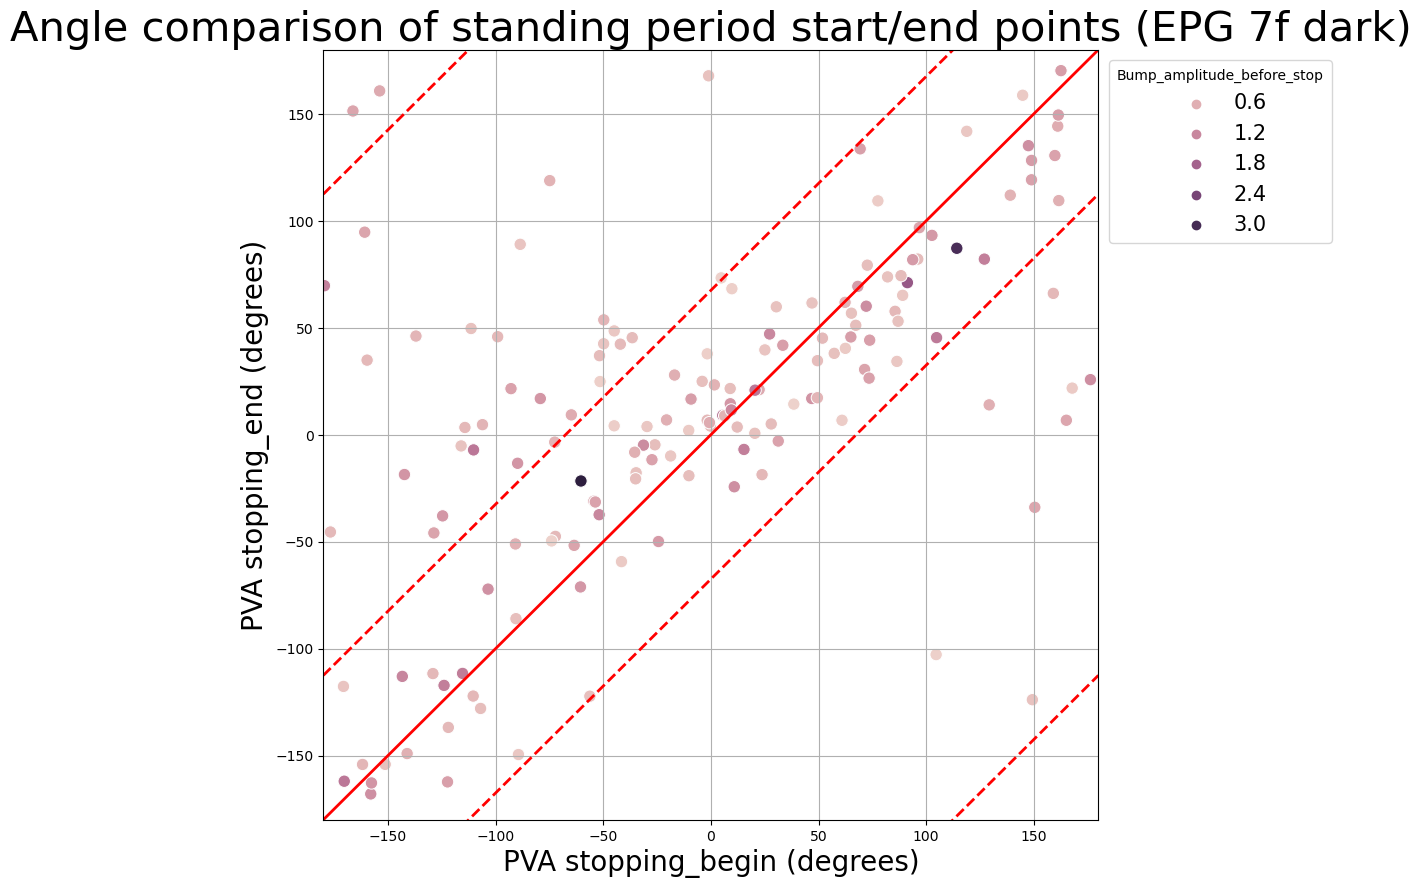

In [39]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (EPG 7f dark)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [40]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

In [41]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))
actual_mean_absolute_angle_diff 

45.53332036041545

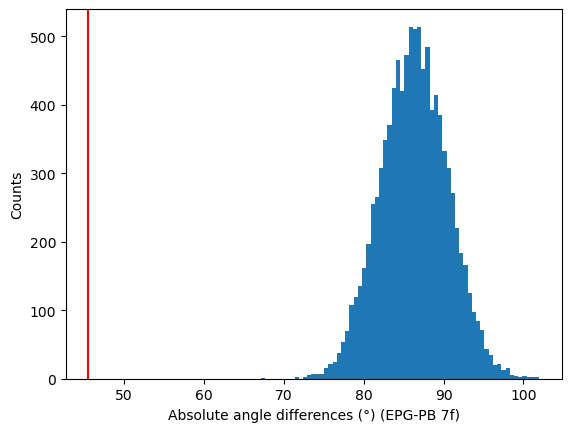

In [42]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (°) (EPG-PB 7f)')
plt.ylabel('Counts')
plt.show()

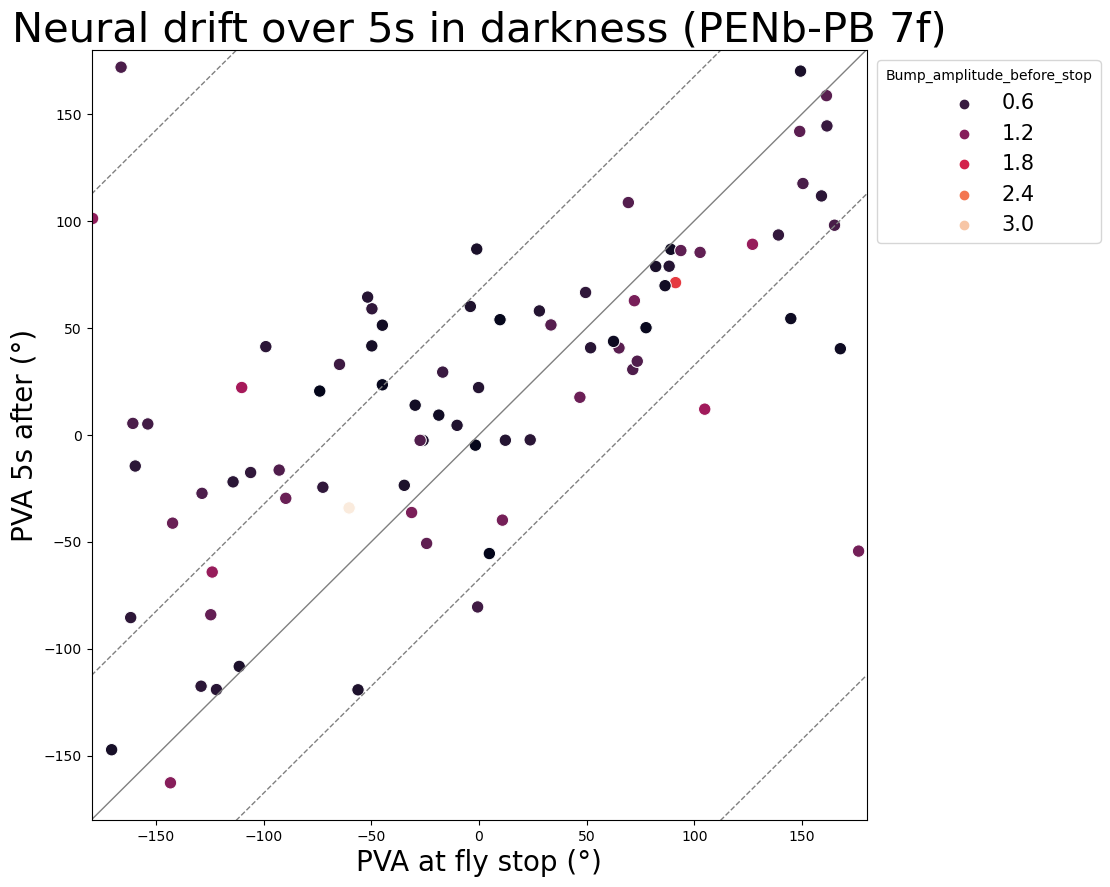

In [43]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_5s_after_stop', palette = 'rocket',hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 5s in darkness (PENb-PB 7f)', fontsize =30)
plt.ylabel('PVA 5s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()

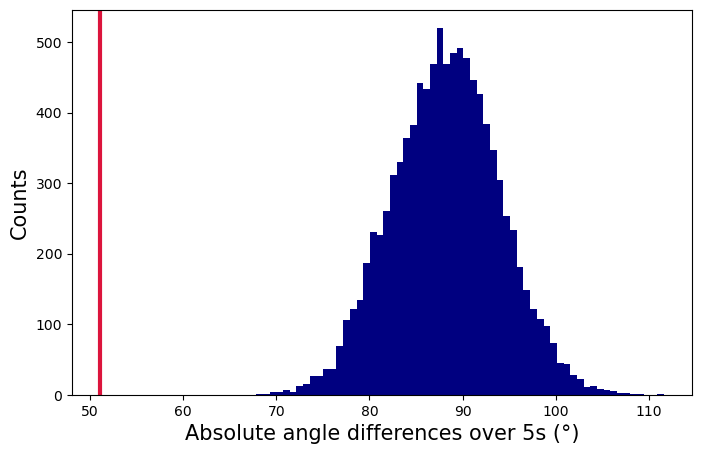

In [44]:
stop_period_start_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)))
stop_period_end_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)
for i in range(len(stop_period_start_5s )):
    stop_period_start_5s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_5s[i] =  persistence_data_pooled['PVA_5s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_5s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_5s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_5s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_5s =  calculate_angle_difference_between_two_time_point(stop_period_start_5s ,stop_period_end_5s)
actual_mean_absolute_angle_diff_5s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_5s))
actual_mean_absolute_angle_diff_5s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto', color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_5s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 5s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()   

In [45]:
actual_mean_absolute_angle_diff_5s

51.06492633175116

In [46]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', palette = 'rocket',hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 10s with visual bar (PENb-EB 7f)', fontsize =30)
plt.ylabel('PVA 10s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()
#a.savefig('E-PG_Bump_Angle_10s_after_cl', format ='svg')

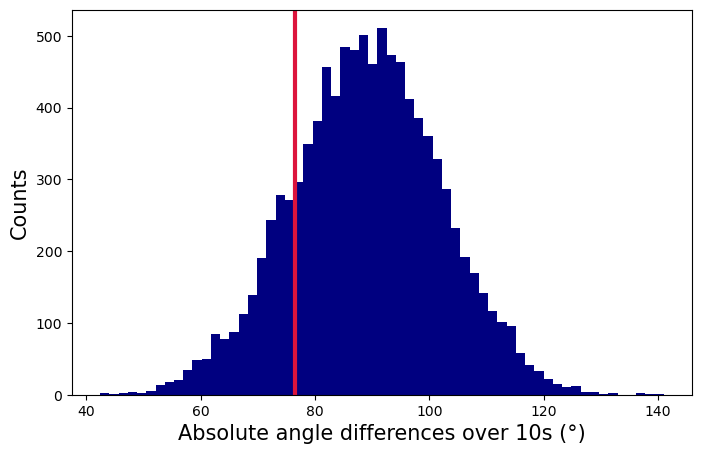

In [47]:
stop_period_start_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)))
stop_period_end_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)
for i in range(len(stop_period_start_10s )):
    stop_period_start_10s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_10s[i] =  persistence_data_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_10s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_10s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_10s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_10s =  calculate_angle_difference_between_two_time_point(stop_period_start_10s ,stop_period_end_10s)
actual_mean_absolute_angle_diff_10s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_10s))
actual_mean_absolute_angle_diff_10s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto',color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_10s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 10s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()

In [48]:
np.quantile(bootstrap_mean_angle_differences_10000,0.00000001)

42.44119838722422

In [49]:
len(long_trial_index)

20

In [50]:
actual_mean_absolute_angle_diff_10s    

76.54239495825635

In [165]:
from scipy.stats import ranksums
ranksums(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff))

RanksumsResult(statistic=2.1769930032767526, pvalue=0.029481089482878878)

In [168]:
np.abs(actual_mean_absolute_angle_diff_dark_diff)

array([ 14.87961551,   7.80586632,  47.23390005,  79.02548716,
        67.89522369,  72.90374147,   6.44418011,  83.89965246,
        45.67931781,  34.7220228 ,  89.94809929,  33.7793294 ,
        11.95102595, 106.38813275,  96.98113109,  61.65251028,
        37.35505887,  45.27456324,  43.50109077,  48.56805248,
        17.00582985,  30.64506027,  33.73333032,  33.16101087,
         4.00494668,   4.52738489,  62.17612688,  43.47679636,
        31.91242704,  36.63364861,  22.33510041,  41.36969363,
         2.13186627,  10.6988293 ,  98.69278054,  26.82273121,
        41.13957456,   5.83297662,   7.89804811,   5.23798731,
       127.88752778,  92.31285218,  45.36758513,  58.98281201,
        39.88346763,  12.85786446,   9.12414438,  39.37562295,
         5.6627056 , 160.14612414, 131.78157191, 105.99356931,
        85.79342256,  73.89373687,  33.29716454,  16.32565582,
         7.1619121 ,  59.54732093,  10.02309617,   2.23834245,
        26.30317926,   9.04141776,  22.45314712,  26.34

In [167]:
stats.mannwhitneyu(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff), alternative = 'two-sided')

MannwhitneyuResult(statistic=3465.0, pvalue=0.0296191376401522)

In [173]:
np.savetxt('angle_difference_cl_10s.csv', np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [56]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [57]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [58]:
persistence_data_pooled

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_at_restart   
0      -157.673166             113.858629  ...                   0.120168  \
1       -55.013859             -65.503918  ...                   0.494114   
2       -24.163843             -84.568892  ...                   0.124029   
3        43.955119              66.408276  ...                   0.502485   
4        96.081117              99.294985  ...                   0.958967   
..             ...                    ...  ...                        ...   
144    -132.141746            -100.250723  ...                   0.254206   
145    -165.264493             142.279049  ...                   0.238209   
146    -120.791635             162.518259  ...                   0.301008   
147    -127.937979            -165.489649  ...                   0.240625   
148      19.296692              47.018918  ...                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                               1.017992                             1.064665   
..                                   ...                                  ...   
144                             0.227604                             0.197644   
145                             0.248334                             0.241640   
146                             0.278209                             0.304520   
147                             0.240952                             0.214188   
148                             0.220290                             0.319481   

     bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                    0.139993                          0.102664  \
1                    0.587214                          0.447535   
2                    0.201707       

In [59]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)